In [170]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import torch
import tqdm
import xarray as xr
from kinds import Compartments
from matplotlib import rcParams
from cycler import cycler

# Initialise a neural network for the infection parameters
from include import neural_net

In [133]:
torch.set_default_device('cpu')
device='cpu'

In [398]:
colors = {
    'c_darkblue': '#2F7194',
    'c_yellow': '#F5DDA9',
    'c_orange': '#EC9F7E',
    'c_red': '#ec7070',
    'c_pink': '#F8A6A6',
    'c_purple': '#A07CB0',
    'c_lightblue': '#97c3d0',
    'c_lightgreen': '#AFD8BC',
    'c_darkgreen': '#48675A',
    'c_lightbrown': '#C6BFA2',
    'c_lightgrey': '#AFC1B9',
    'c_darkgrey': '#3D4244',
}

rcParams['text.usetex'] = False
rcParams['axes.prop_cycle'] = cycler(color=list(colors.values()))
rcParams['font.family'] = ['Garamond Premier Pro', 'KaiTi']
rcParams['mathtext.fontset'] = 'custom'
rcParams['mathtext.rm'] = 'Garamond Premier Pro'
rcParams['mathtext.it'] = 'Garamond Premier Pro:italic'
rcParams['mathtext.bf'] = 'Garamond Premier Pro:bold'
rcParams['axes.grid'] = False
rcParams['axes.spines.top'] = False
rcParams['axes.spines.bottom'] = True
rcParams['axes.spines.left'] = True
rcParams['axes.spines.right'] = False
rcParams['figure.dpi'] = 400
fs = 8
rcParams.update(**{
    "font.size": fs, 
    "axes.titlesize": fs,
    "axes.labelsize": fs,
    "xtick.labelsize": fs,
    "ytick.labelsize": fs,
    "legend.fontsize": fs,
})

In [108]:
infected_estimated = pd.read_csv("/Users/thomasgaskin/Downloads/daily-new-estimated-infections-of-covid-19.csv")
infected_estimated = infected_estimated[infected_estimated.Code == "JPN"].set_index("Day")

# Load the infection data
infection_data = pd.read_csv("/Users/thomasgaskin/Opinion_Dynamics_and_Covid/Infection_data/Our_World_In_Data/owid-covid-data.csv").drop(["continent", "location"], axis=1).set_index('date')
infection_data.index = pd.to_datetime(infection_data.index)
infection_data = infection_data[infection_data.iso_code=="JPN"].sort_index()

---
# Japanese infection data
---

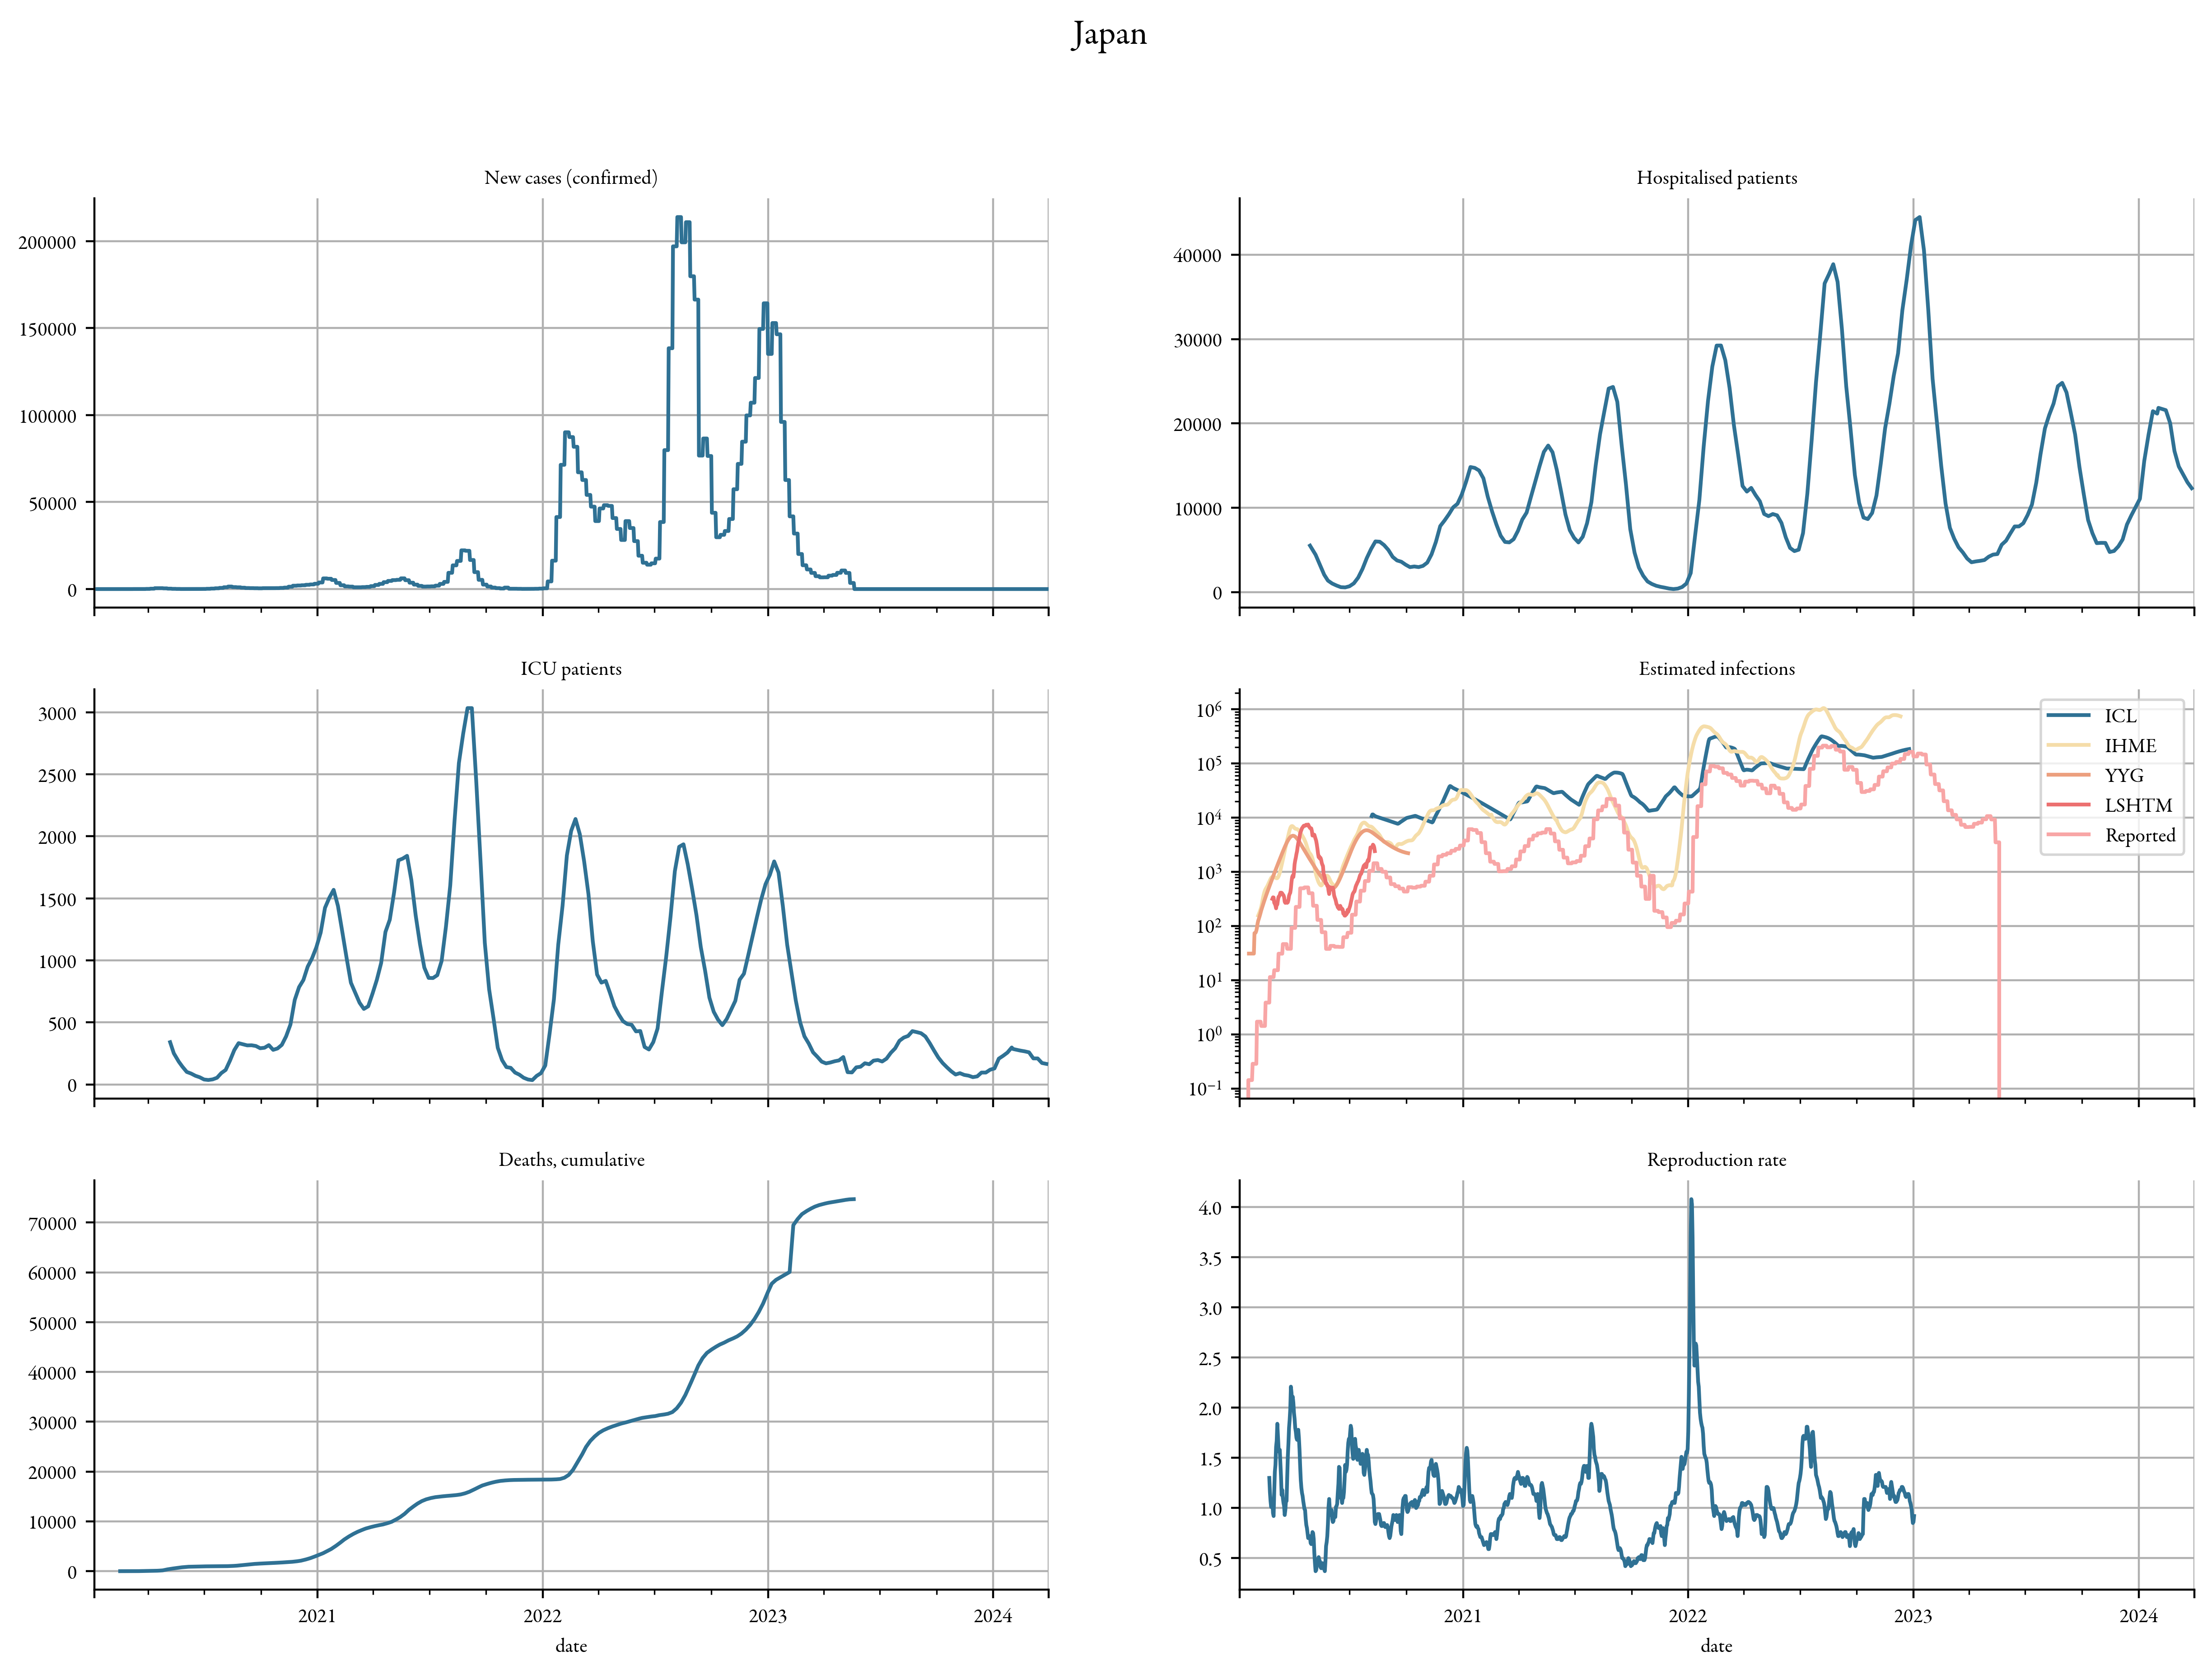

In [4]:
# Plot 
fig, axs = plt.subplots(figsize=(15, 10), nrows=3, ncols=2, sharex=True)
for idx, kind in enumerate(['new_cases_smoothed', 'hosp_patients', 'icu_patients']):
    d = infection_data[kind].dropna()
    d.plot.line(ax=axs.flatten()[idx]) #.replace(0, np.nan).dropna().interpolate(axis=0, method='time').plot.line(ax=axs.flatten()[idx], label=kind)
    axs.flatten()[idx].grid()
    axs.flatten()[idx].set_title(kind)
infection_data['new_deaths_smoothed'].replace(0, np.nan).dropna().interpolate(axis=0, method='time').cumsum(axis="index").plot.line(ax=axs.flatten()[4], label="Deaths, cumulative")
infected_estimated.index = pd.to_datetime(infected_estimated.index)
infected_estimated = infected_estimated.sort_index()
infected_estimated.plot.line(ax=axs.flatten()[3])
axs.flatten()[4].grid()
axs.flatten()[0].set_title("New cases (confirmed)")
axs.flatten()[1].set_title("Hospitalised patients")
axs.flatten()[2].set_title("ICU patients")
axs.flatten()[3].set_title("Estimated infections")
axs.flatten()[3].grid()
axs.flatten()[3].legend(labels=['ICL', 'IHME', 'YYG', 'LSHTM', 'Reported'])
axs.flatten()[4].set_title("Deaths, cumulative")
axs.flatten()[3].set_yscale('log')
infection_data['reproduction_rate'].plot.line(ax=axs.flatten()[-1])
axs.flatten()[-1].grid()
axs.flatten()[-1].set_title("Reproduction rate")
fig.suptitle("Japan", fontsize=14);

---
# Variants: Japan
---

In [5]:
import json
with open("/Users/thomasgaskin/Downloads/perCountryData.json") as f:
    d = json.load(f)

country_keys = dict((d['regions'][0]['distributions'][idx]['country'], idx) for idx in range(len(d['regions'][0]['distributions'])))
variants_japan = d['regions'][0]['distributions'][country_keys['Japan']]
del d

In [6]:
v = pd.concat([pd.DataFrame.from_dict({pd.to_datetime(variants_japan['distribution'][i]['week']): [v/variants_japan['distribution'][i]['total_sequences'] for v in variants_japan['distribution'][i]['cluster_counts'].values()]}, orient='index', columns=[k for k in variants_japan['distribution'][i]['cluster_counts'].keys()]) for i in range(len(variants_japan['distribution']))])

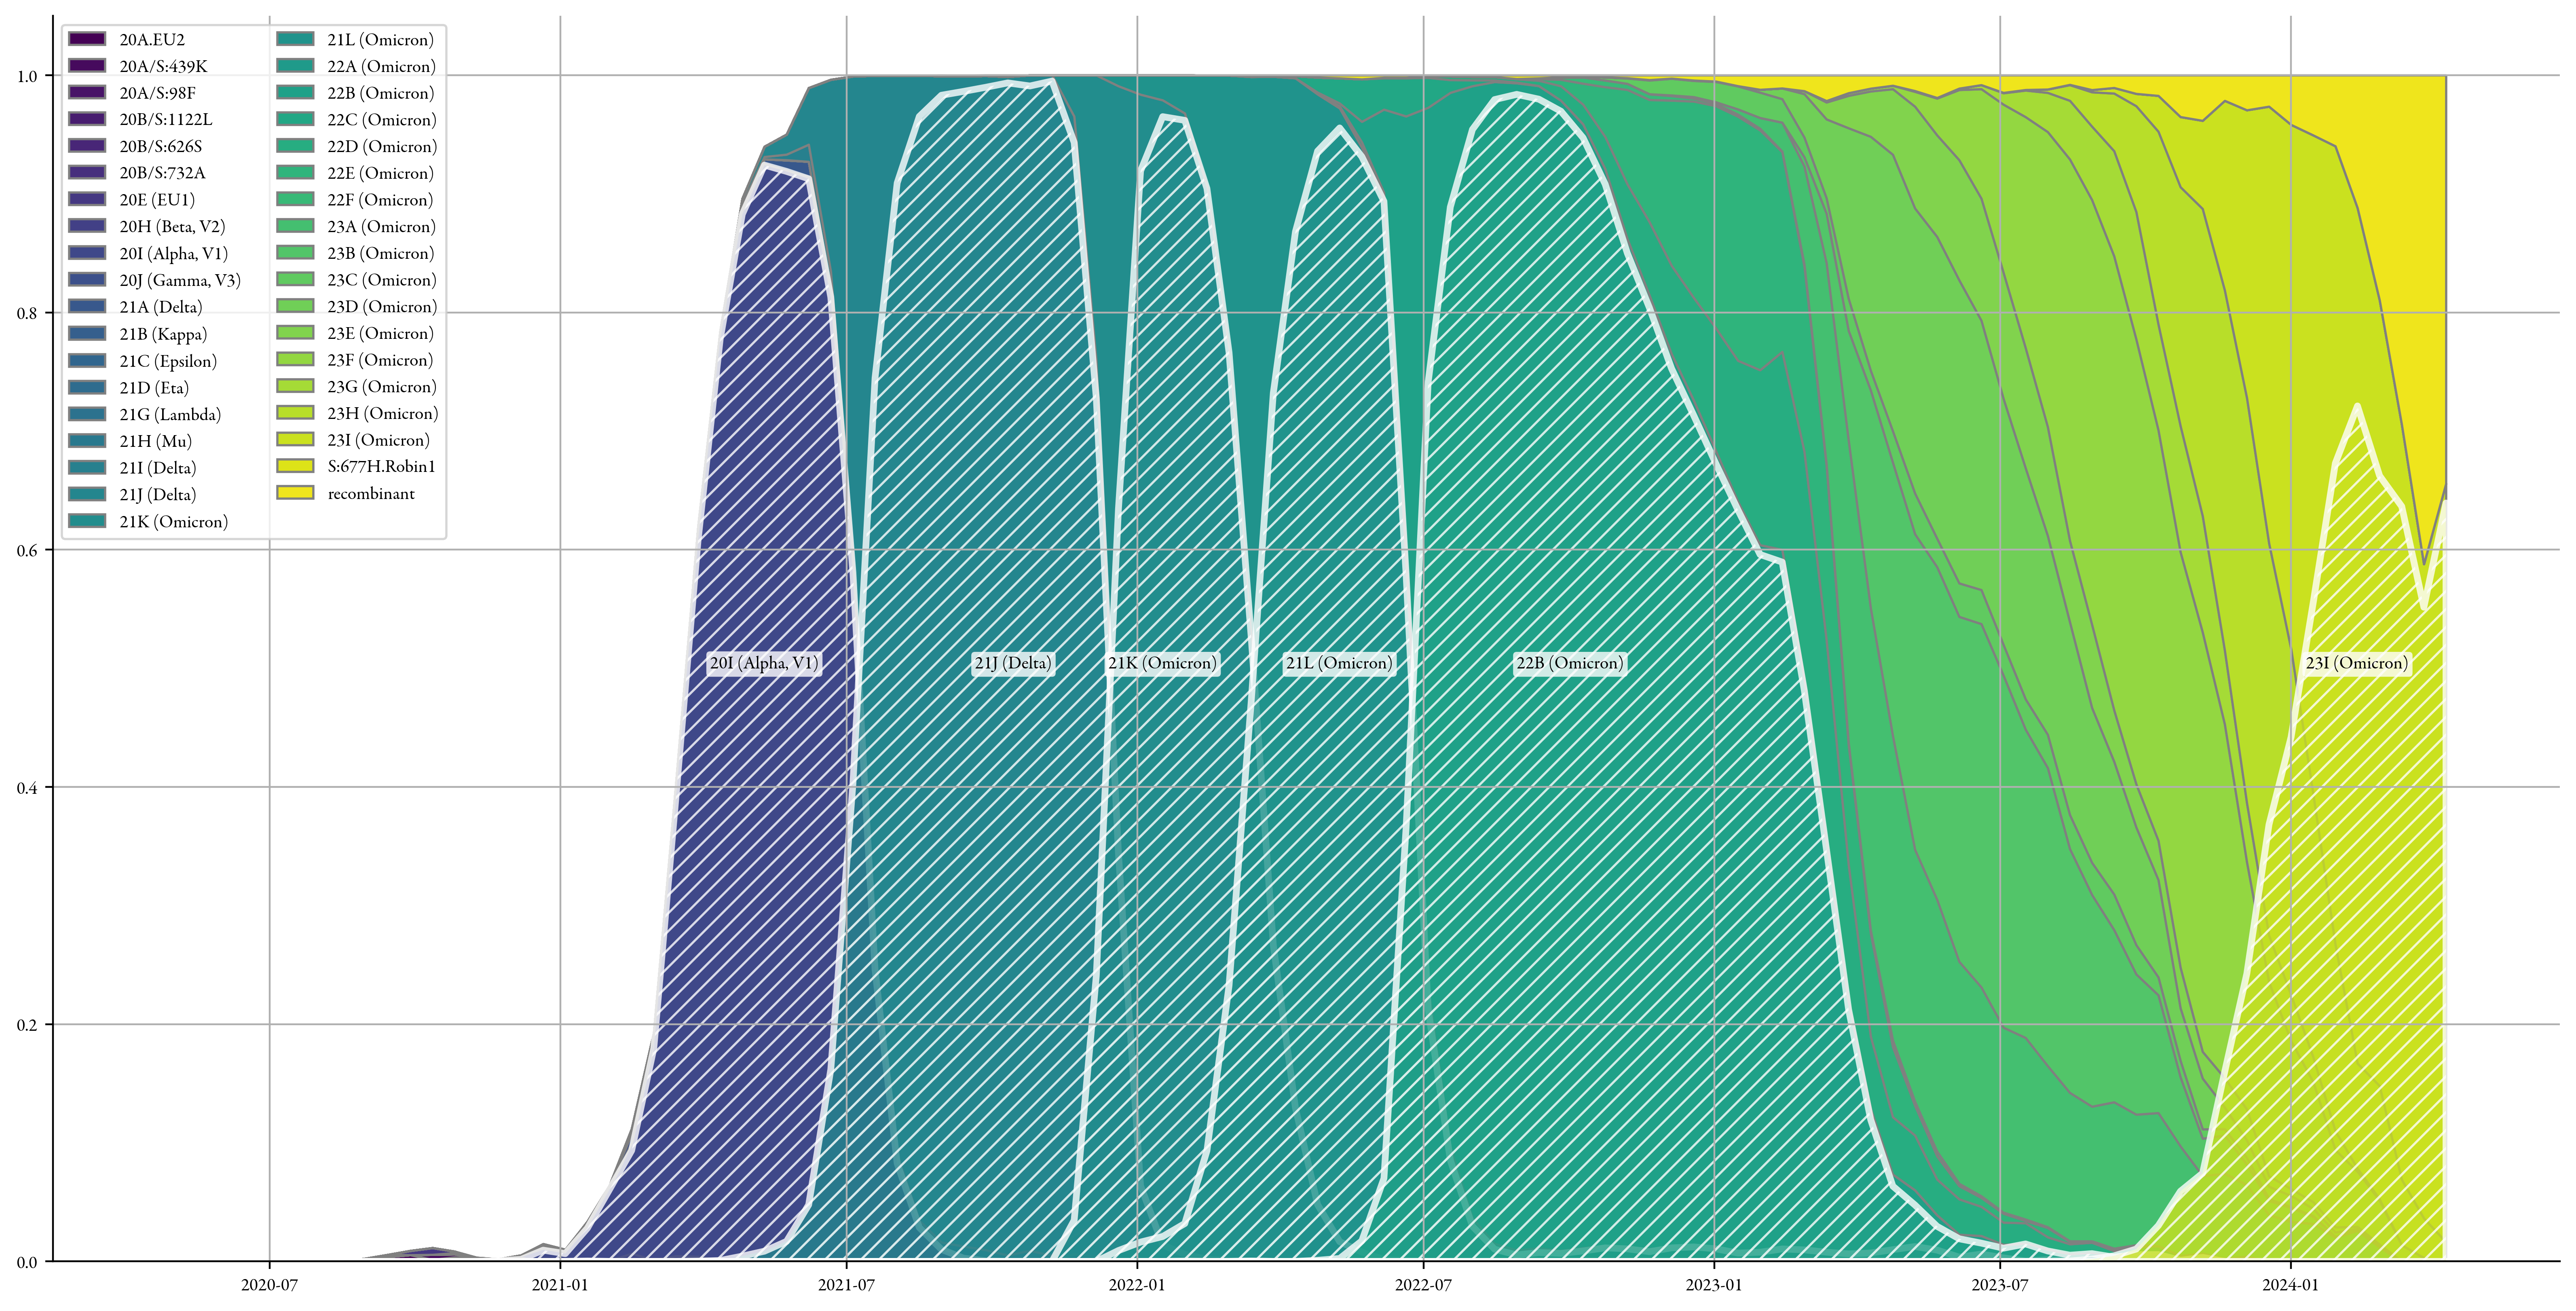

In [7]:
fig, ax = plt.subplots(figsize=(20, 10))
cmap = plt.colormaps.get_cmap('viridis')
ax.stackplot(v.index, *(v[v.columns[i]] for i in range(len(v.columns))), labels=v.columns, colors=[cmap(i/len(v.columns)) for i in range(len(v.columns))], alpha=1, ec='gray')
ax.grid()
ax.legend(ncols=2, loc='upper left')

for i in range(len(v.columns)):
    if v[v.columns[i]].max() > 0.5:
        ax.fill_between(v.index, v[v.columns[i]], color=plt.colormaps.get_cmap('viridis')(i/len(v.columns)), ec='white', lw=3, alpha=0.8, hatch='///')
        ax.text(v[v[v.columns[i]]==v[v.columns[i]].max()].index, 0.5, v.columns[i], ha='center' if v.columns[i] not in ['21J (Delta)', '22B (Omicron)'] else 'right' if v.columns[i] != '22B (Omicron)' else 'left', bbox=dict(pad=0.1, lw=0, color='white', alpha=0.8, boxstyle="Round, pad=0.2"))

In [8]:
# Calculate densities
N = infection_data["population"].mean()
infection_densities = pd.concat([
    infection_data['hosp_patients'].resample('D').interpolate(axis=0, method='time'),
    infection_data['icu_patients'].resample('D').interpolate(axis=0, method='time'),
], axis=1, ignore_index=False)[14:]
infection_densities["symptomatic"] = infection_data['new_cases_smoothed']#[infection_data['new_cases'] > 0].resample('D').interpolate(method='time', axis=0)
infection_densities["deaths_cumulative"] = infection_data['new_deaths'][infection_data['new_deaths'] > 0].resample('D').interpolate(method='time', axis=0).cumsum()
infection_densities["I"] = infected_estimated['Daily new estimated infections of COVID-19 (IHME, mean)']
infection_densities.columns = ["H", "C", "SY", "D", "I"]
infection_densities = infection_densities[["I", "SY", "H", "C", "D"]]
infection_densities /= N

In [9]:
intervals = [pd.to_datetime("2020-03-25"), pd.to_datetime("2020-04-07"), pd.to_datetime("2020-05-25"), infection_densities.index[250]]
interval_idx = [np.where(infection_densities.index == intervals[i])[0].item() for i in range(4)]
interval_idx

[66, 79, 127, 250]

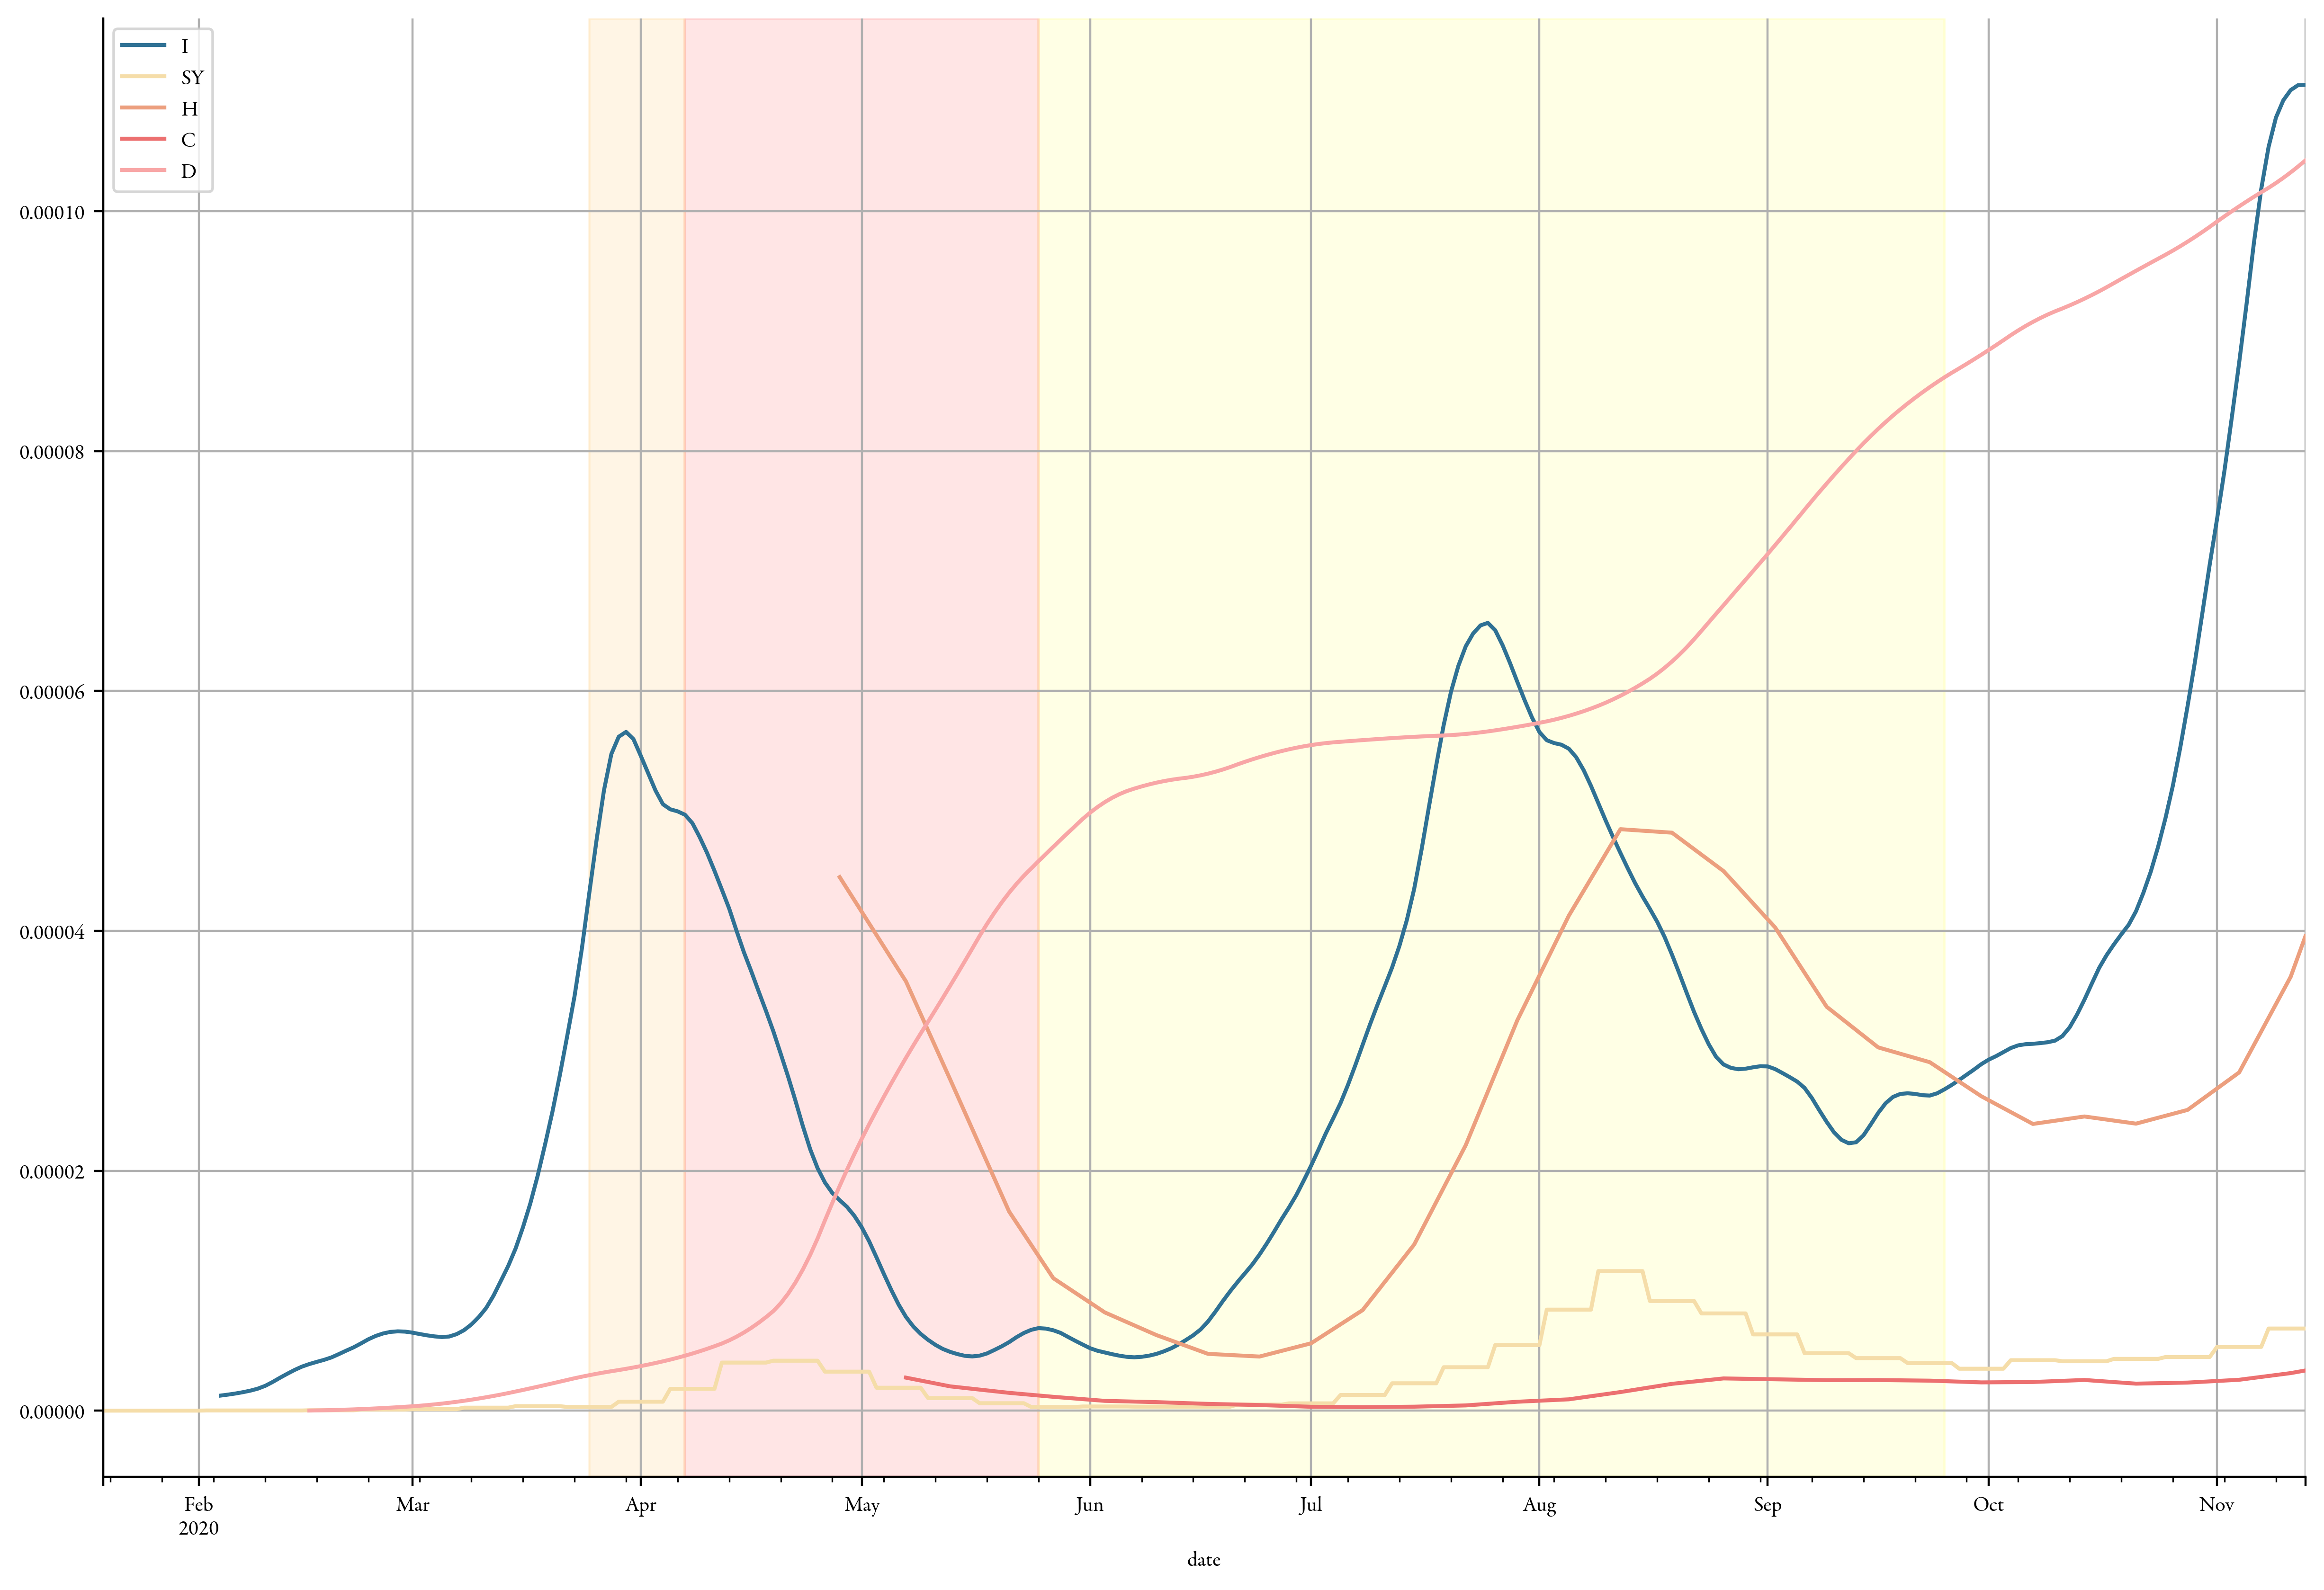

In [10]:
fig, ax = plt.subplots(figsize=(15, 10))
infection_densities[:300].plot.line(ax=ax)
ax.grid()
ax.axvspan(*intervals[0:2], color='orange', alpha=0.1) # press conference asking residents to refrain from non-essential outings
ax.axvspan(*intervals[1:3], alpha=0.1, color='red') # state of emergency declared
ax.axvspan(*intervals[2:4], alpha=0.1, color='yellow')

---
# Step 1: Model calibration
---

In [135]:
def SEIRD(state: torch.Tensor, parameters: dict, *, dt: float) -> torch.Tensor:
    
    current_state = state[-1].clone()
    new_state = torch.clip(current_state + torch.stack([
        
        # Susceptible
        - parameters["k_E"] * state[-1][Compartments.susceptible.value] * state[-1][Compartments.infected.value],
        
        # Exposed
        + parameters["k_E"] * state[-1][Compartments.susceptible.value] * state[-1][Compartments.infected.value] - parameters["k_I"] * state[int(max(-parameters["tau_I"], -len(state)))][Compartments.exposed.value],
        
        # Infected
        + parameters["k_I"] * state[int(max(-parameters["tau_I"], -len(state)))][Compartments.exposed.value] - parameters["k_SY"]* state[int(max(-parameters["tau_SY"], -len(state)))][Compartments.infected.value] - parameters["k_R"]*state[int(max(-parameters["tau_R"], -len(state)))][Compartments.infected.value],
        
        # Symptomatic after incubation period
        + parameters['k_SY'] * state[int(max(-parameters["tau_SY"], -len(state)))][Compartments.infected.value] - parameters["k_H"] * state[int(max(-parameters["tau_H"], -len(state)))][Compartments.symptomatic.value] - parameters["k_R"] * state[int(max(-parameters["tau_R"], -len(state)))][Compartments.symptomatic.value],
        
        # Recovered
        + parameters["k_R"] * (state[int(max(-parameters["tau_R"], -len(state)))][Compartments.infected.value] + state[int(max(-parameters["tau_R"], -len(state)))][Compartments.hospitalized] + state[int(max(-parameters["tau_R"], -len(state)))][Compartments.critical.value] + state[int(max(-parameters["tau_R"], -len(state)))][Compartments.symptomatic.value]),
        
        # Hospitalized
        + parameters["k_H"] * state[int(max(-parameters["tau_H"], -len(state)))][Compartments.symptomatic.value] - parameters["k_C"] * state[int(max(-parameters["tau_C"], -len(state)))][Compartments.hospitalized.value] - parameters["k_R"] * state[int(max(-parameters["tau_R"], -len(state)))][Compartments.hospitalized.value],

        # Critical
        + parameters["k_C"] * state[int(max(-parameters["tau_C"], -len(state)))][Compartments.hospitalized.value] - parameters["k_D"] * state[int(max(-parameters["tau_D"], -len(state)))][Compartments.critical.value] - parameters["k_R"] * state[int(max(-parameters["tau_R"], -len(state)))][Compartments.critical.value],
        
        # Deceased
        + parameters["k_D"] * state[int(max(-parameters["tau_D"], -len(state)))][Compartments.critical.value]
        
    ]) * dt, 0, 1)
    
    return new_state

In [136]:
parameters = dict(k_E=0.5, k_I=0.3, k_SY=0.05, k_H=0.01, k_C=0.005,  k_D=0.1, k_R=0.01, 
                  tau_I=1, tau_SY=1, tau_H=1, tau_C=1, tau_R=1, tau_D=2)
init_state = torch.zeros(8, 1, dtype=torch.float)
init_state[
    Compartments.susceptible.value
] = 0.99  # High number of susceptible agents
init_state[Compartments.infected.value] = (
    1.0 - init_state[Compartments.susceptible.value]
)  # Some infected agents

time_series = [init_state]

for _n in range(800):
    time_series.append(SEIRD(time_series, parameters, dt=0.2))
time_series = torch.stack(time_series)

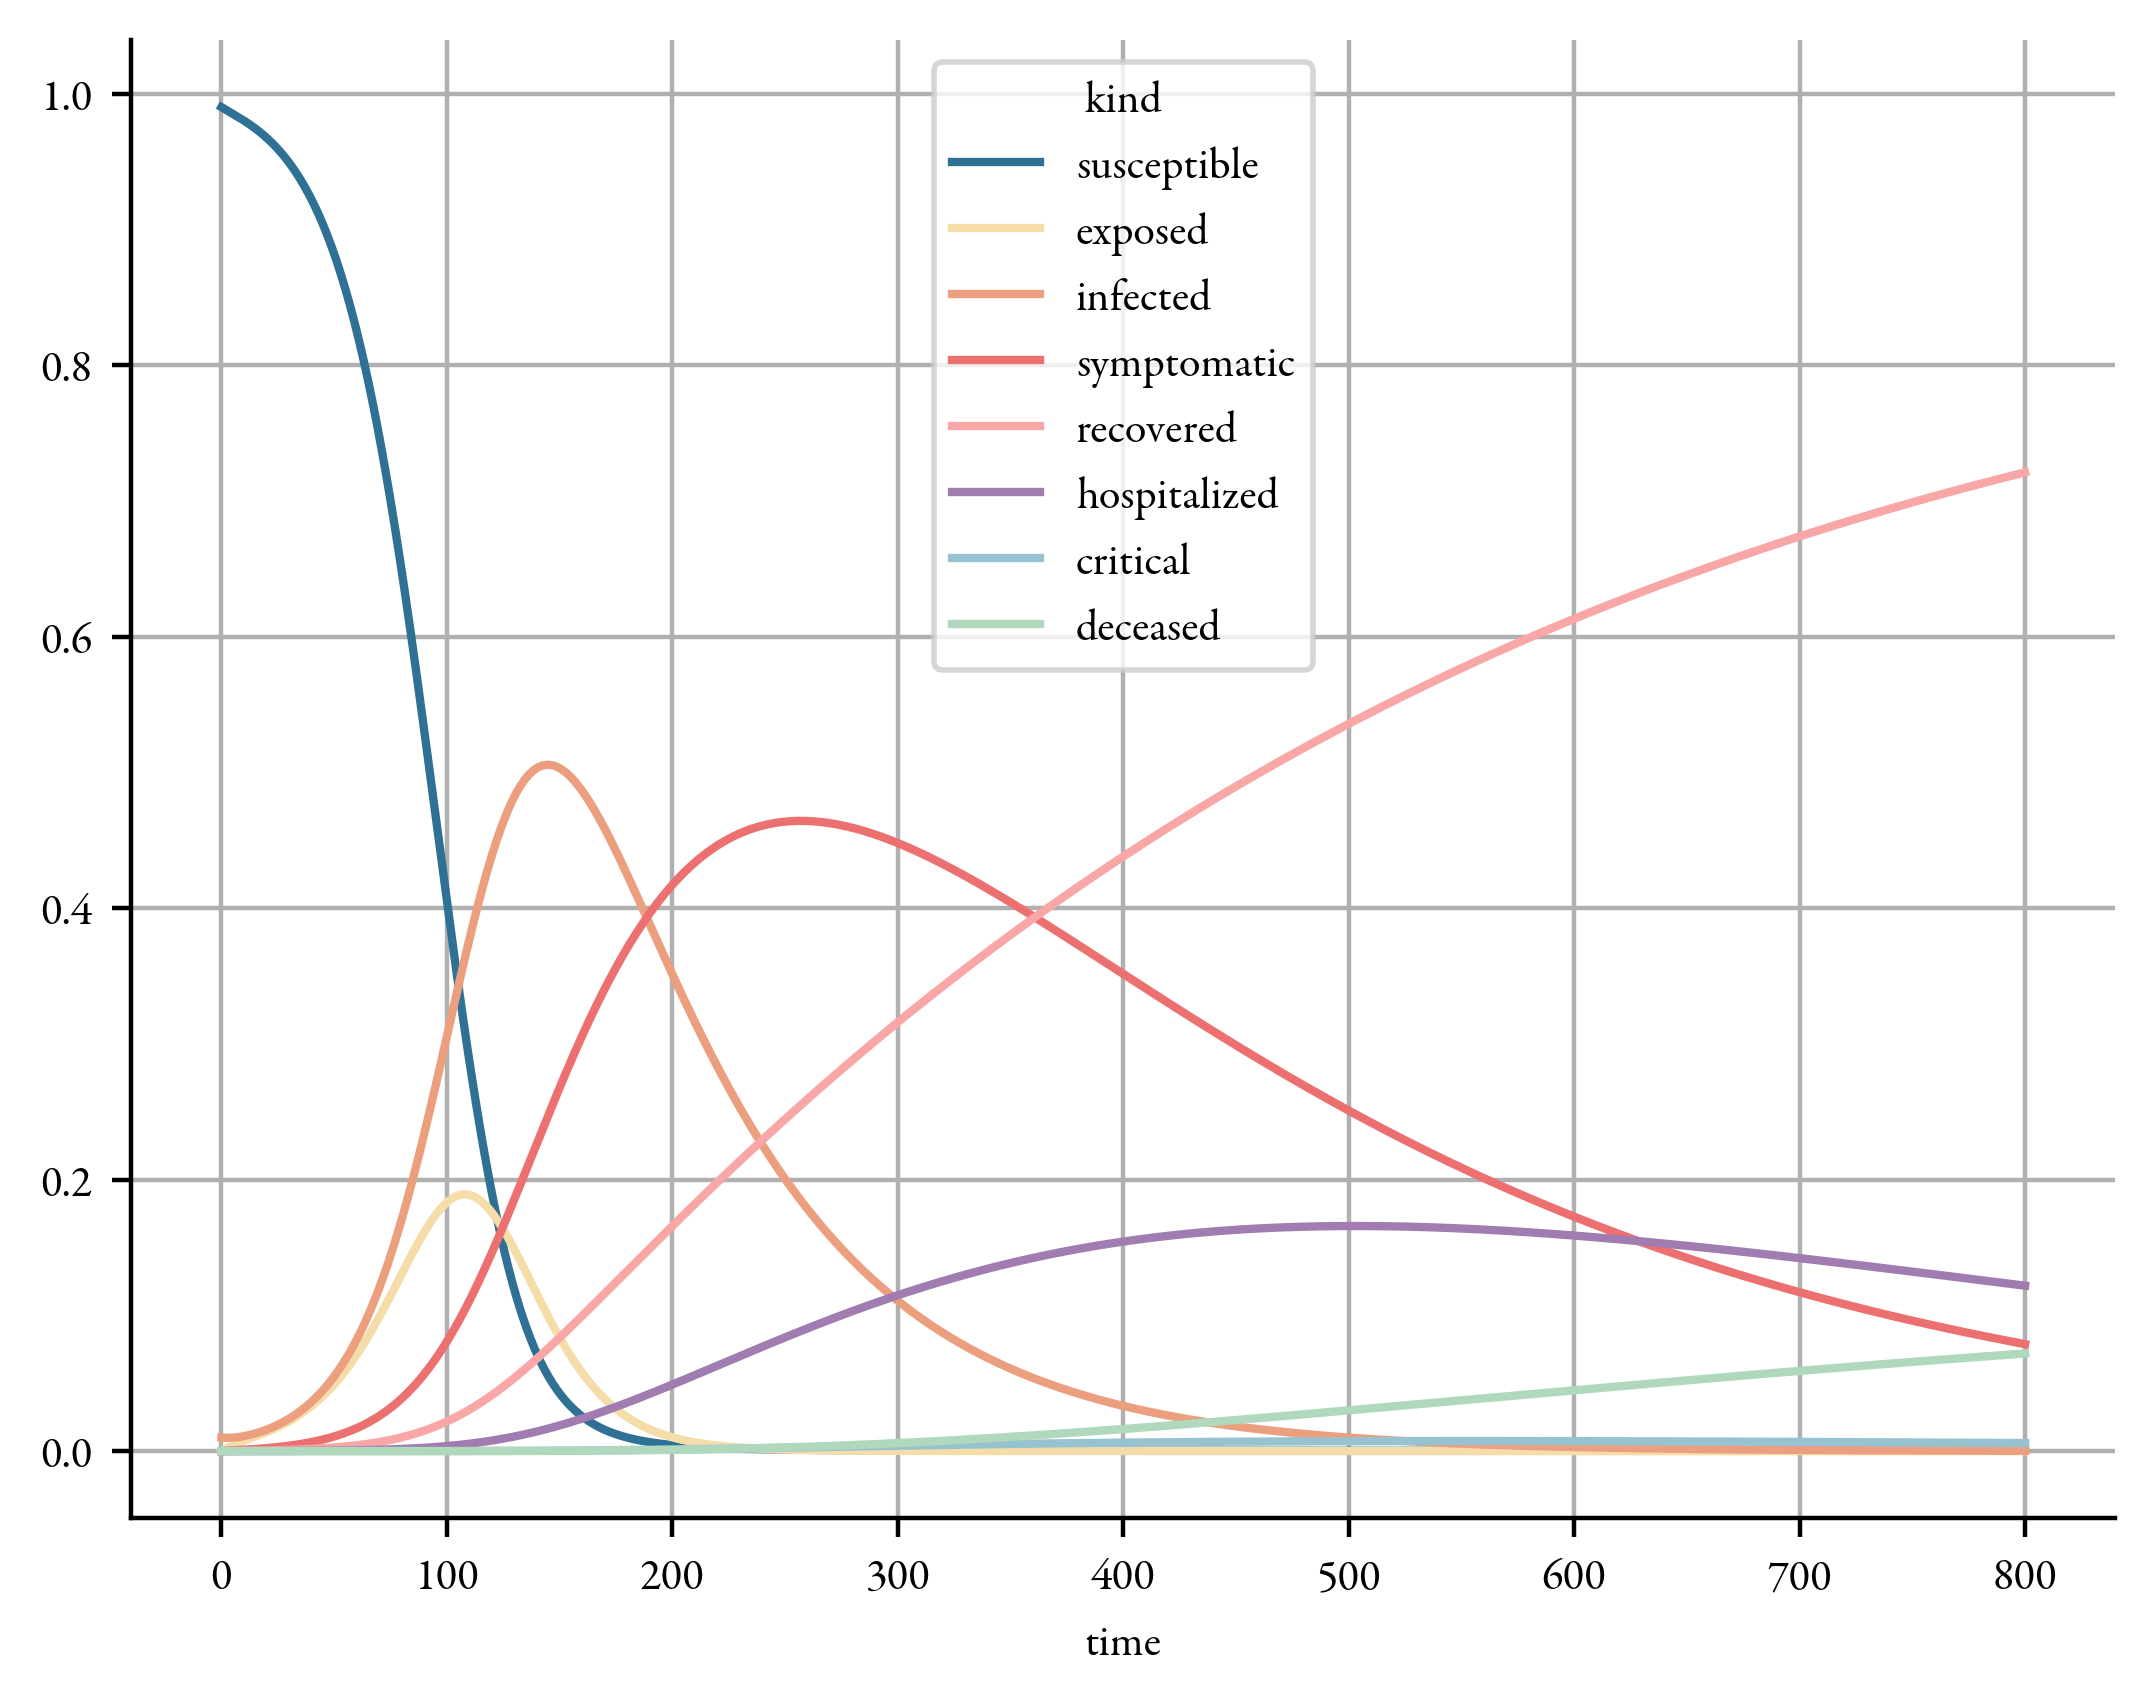

In [13]:
fig, ax = plt.subplots()
ax.grid()
time_series = xr.DataArray(time_series.squeeze(), dims=["time", "kind"], coords={"time": np.arange(time_series.shape[0]), "kind": [e.name for e in Compartments]})
time_series.plot(hue="kind", ax=ax);

In [137]:
training_data = torch.from_numpy(infection_densities[:250].to_numpy(dtype=np.float32)).float().to(device)
training_data_mask = training_data > 0
input_data = N*torch.where(training_data_mask, training_data, 0.0)
input_data -= input_data.mean(dim=0)

In [138]:
len(training_data)

250

In [176]:
n_seed = 12

In [244]:
NN_infection = [neural_net.NeuralNet(
    input_size = 5, # We have five compartments
    output_size = 12 + len(training_data),
    num_layers=5,
    nodes_per_layer={"default": 30}, 
    activation_funcs={"default": "sigmoid", "layer_specific": {-1: "abs"}}, 
    biases={"default": [-1, 1]}
).to(device) for _ in range(n_seed)]

# Initial state of infection
initial_state = torch.tensor([1-102/N, 100/N, 1/N, 1/N, 0, 0, 0, 0], dtype=torch.float32).to(device)

In [245]:
# Initial state: one infected (Jan 19 2020)
batch_size = 10
n_epochs = 2000
for idx, _nn in (pbar := tqdm.tqdm(enumerate(NN_infection), total = n_seed * n_epochs)):
    for e in range(n_epochs):
        
        state = [initial_state.clone()]
        parameters = _nn(input_data[0])
        
        # Run the simulation for b steps:
        for _ in range(training_data.shape[0]-1):
            
            # Make a parameter prediction
            state.append(SEIRD(state, {'k_E': parameters[_+12], 
                                              'k_I': parameters[0], 
                                              'k_SY': parameters[1],
                                              'k_R': parameters[2], 
                                              'k_H': parameters[3], 
                                              'k_C': parameters[4], 
                                              'k_D': parameters[5], 
                                           'tau_I': 1+10*parameters[6], 
                                           'tau_SY': 1+10*parameters[7], 
                                           'tau_H': 1+10*parameters[8], 
                                           'tau_C': 1+10*parameters[9],
                                           'tau_R': 1+10*parameters[10], 
                                           'tau_D': 1+10*parameters[11]}, 
                              dt=0.1))
        loss = torch.nn.functional.mse_loss(
            torch.stack(state)[1:, [Compartments.infected.value, Compartments.symptomatic.value, Compartments.hospitalized.value, Compartments.critical.value, Compartments.deceased.value]][training_data_mask[1:]], 
            training_data[1:][training_data_mask[1:]], reduction='sum',
        )
        loss.backward()
        _nn.optimizer.step()
        _nn.optimizer.zero_grad()
        pbar.set_description(f"seed: {idx}, {loss.detach()}")
        pbar.update(1)

seed: 11, 1.1795277643500413e-08:   0%|          | 12/4000 [06:54<38:16:26, 34.55s/it]


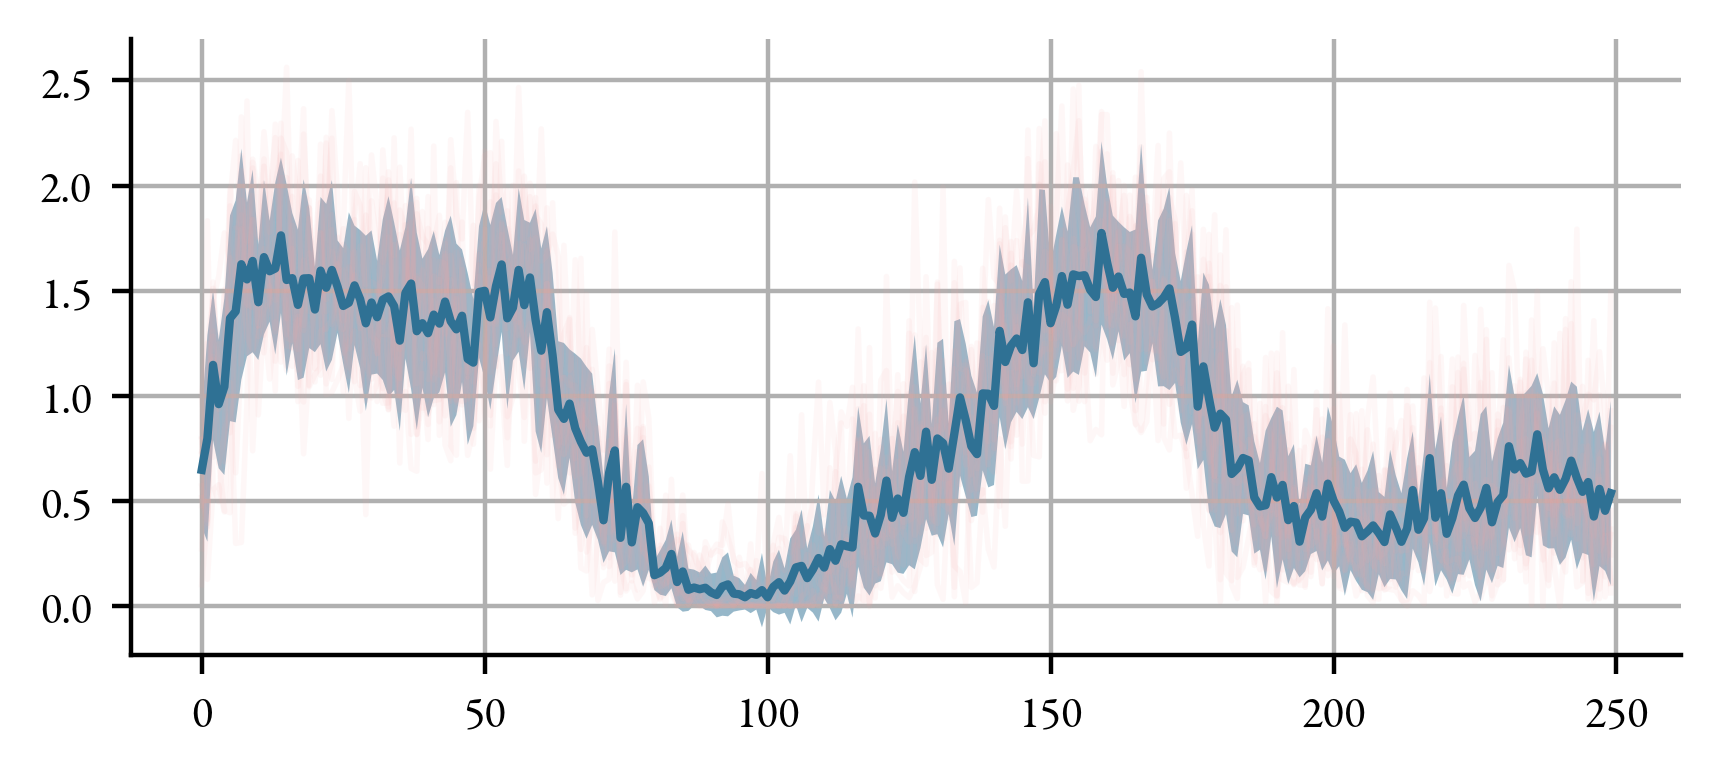

In [250]:
fig, ax = plt.subplots(figsize=(5, 2))
for _nn in NN_infection:
    _k = _nn(input_data[0]).detach()[12:]
    ax.plot(np.arange(len(_k)), _k, lw=1, color=colors['c_pink'], alpha=1/len(NN_infection))
ax.grid()

k_E_train = torch.stack([_nn(input_data[0]).detach()[12:] for _nn in NN_infection])
ax.fill_between(np.arange(k_E_train.shape[1]), k_E_train.mean(axis=0)-k_E_train.std(axis=0), k_E_train.mean(axis=0)+k_E_train.std(axis=0), alpha=0.5)
ax.plot(np.arange(k_E_train.shape[1]), torch.stack([_nn(input_data[0]).detach()[12:] for _nn in NN_infection]).mean(axis=0))

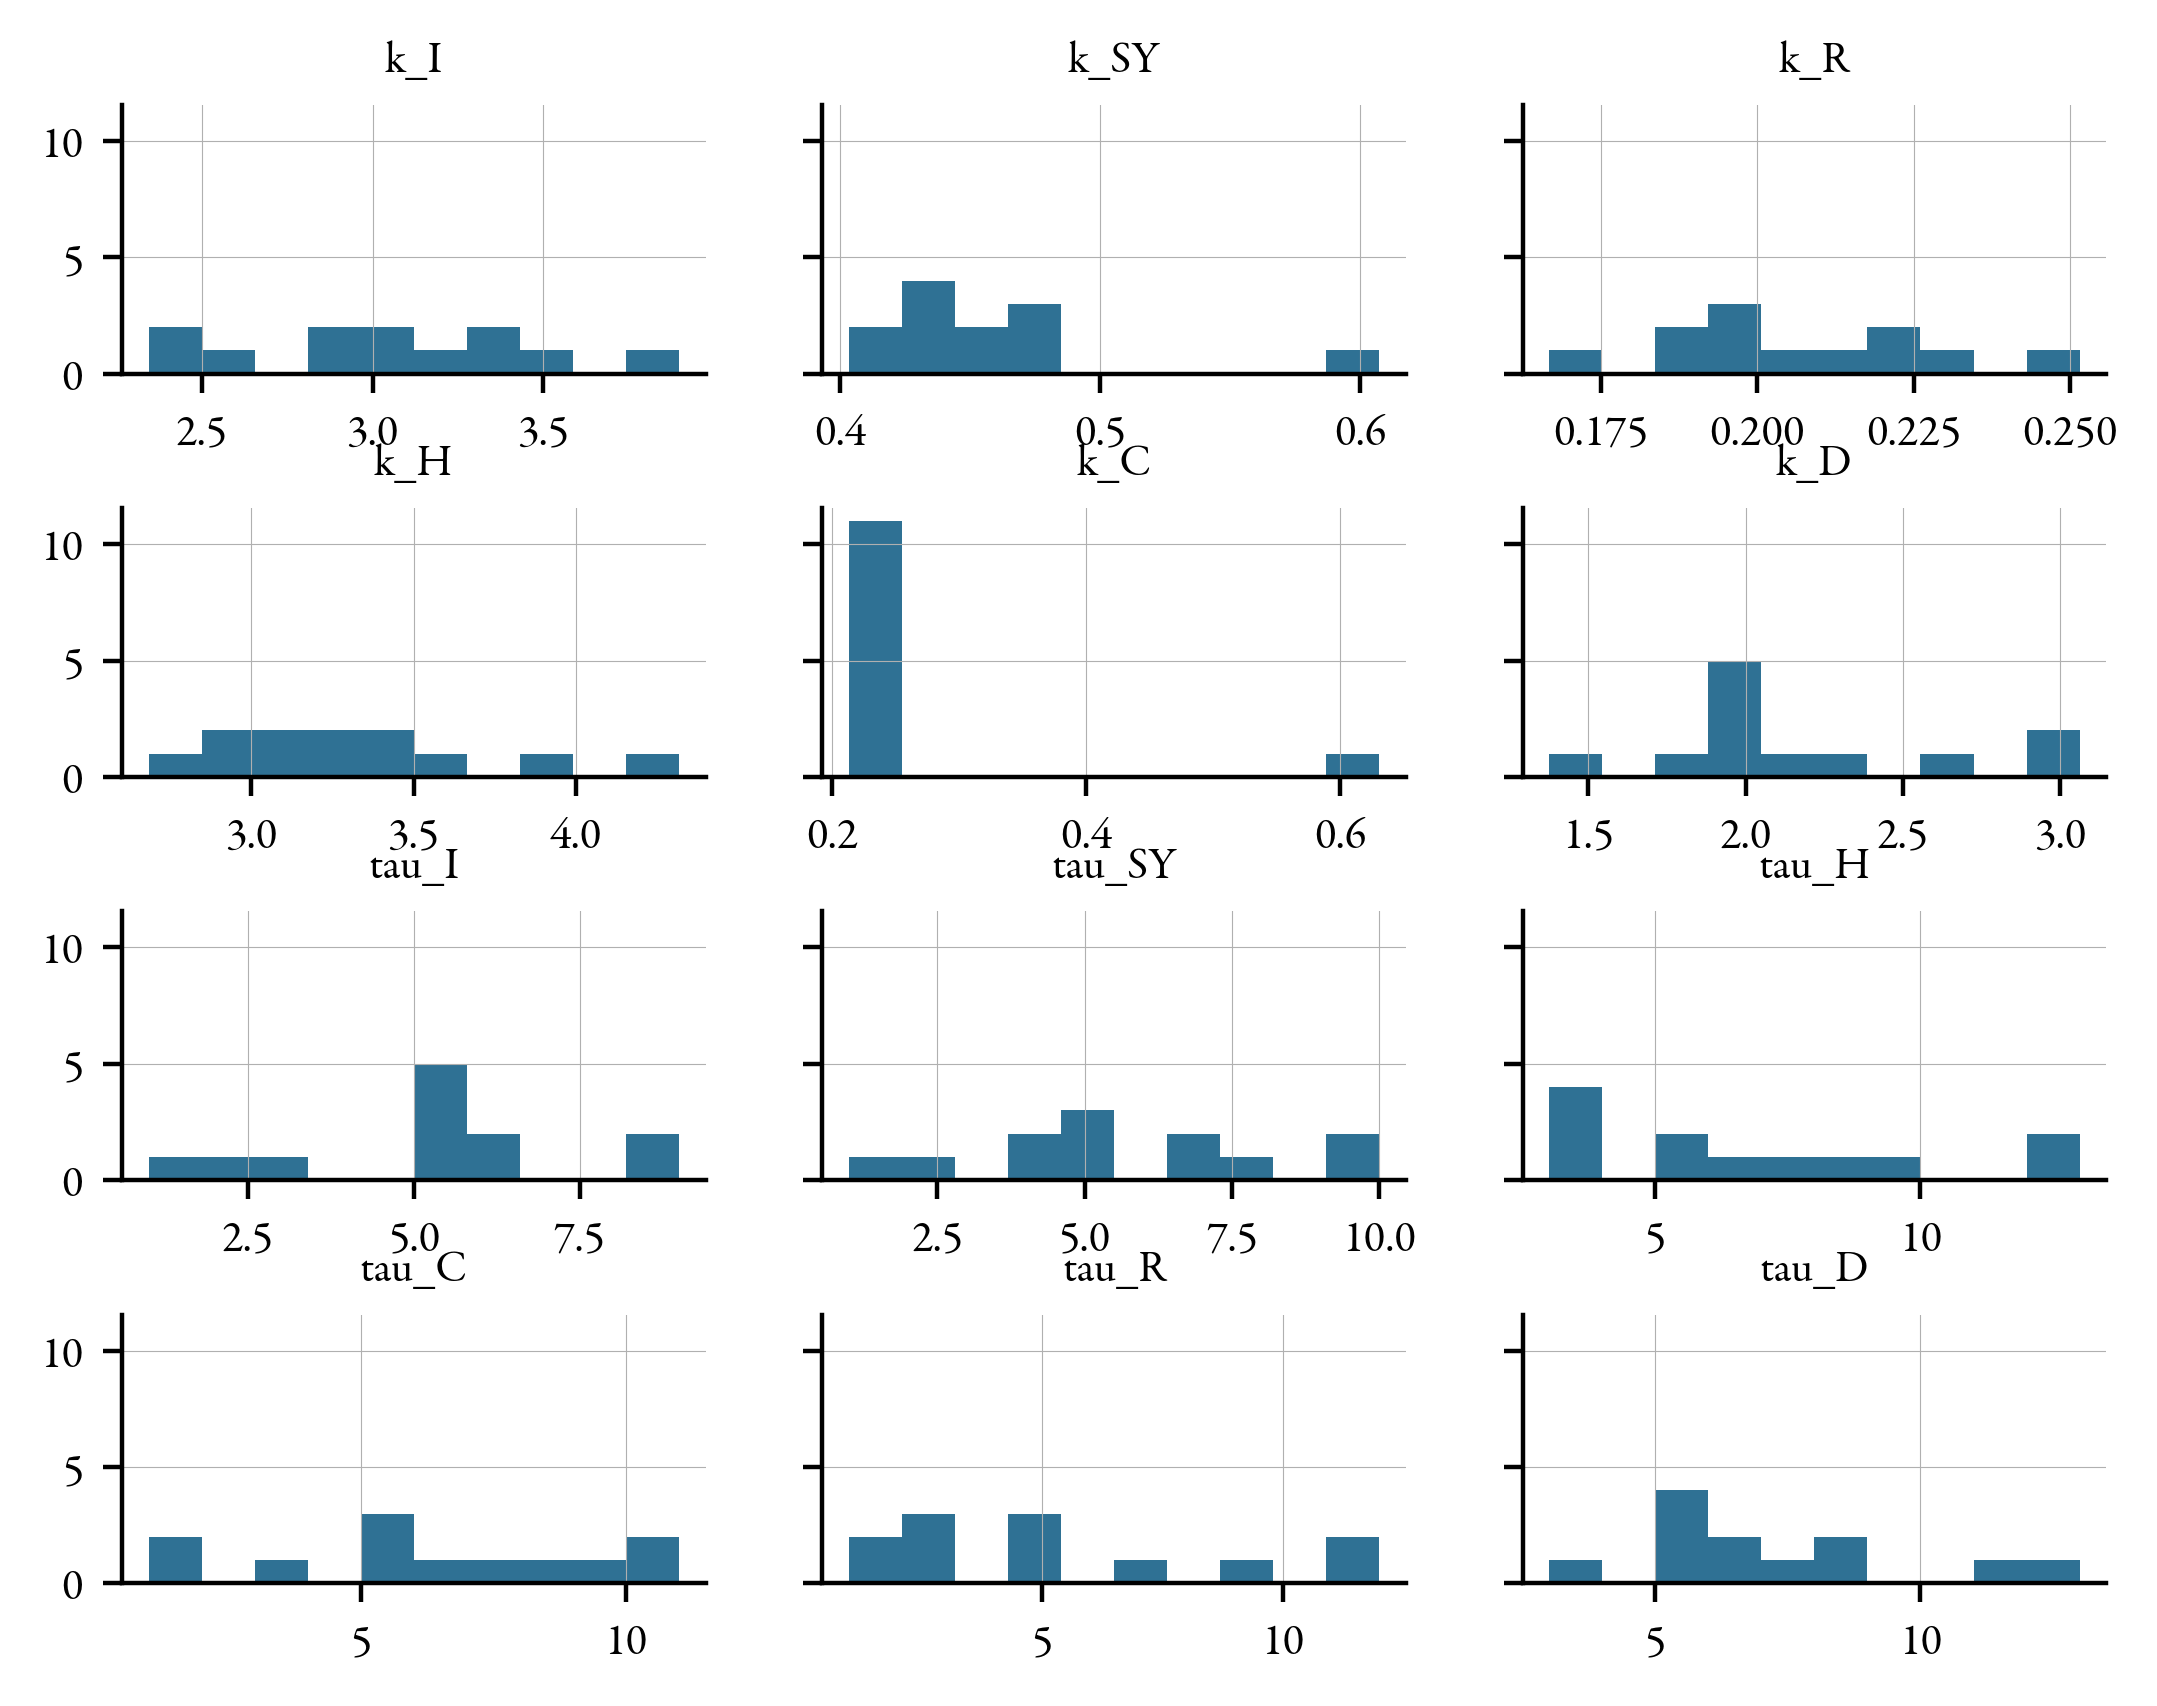

In [247]:
fig, axs = plt.subplots(ncols=3, nrows=4, sharey=True, sharex=False, gridspec_kw=dict(wspace=0.2, hspace=0.5))
pnames = ['k_I', 'k_SY', 'k_R', 'k_H', 'k_C', 'k_D', 'tau_I', 'tau_SY', 'tau_H', 'tau_C', 'tau_R', 'tau_D']
for idx in range(len(axs.flatten())):
    axs.flatten()[idx].hist([1+int(10*_nn(input_data[0]).detach()[idx]) if idx > 5 else _nn(input_data[0]).detach()[idx] for _nn in NN_infection], bins=10)
    axs.flatten()[idx].set_title(pnames[idx])
    axs.flatten()[idx].grid(lw=0.2)

Text(0.5, 1.0, 'Prediction')

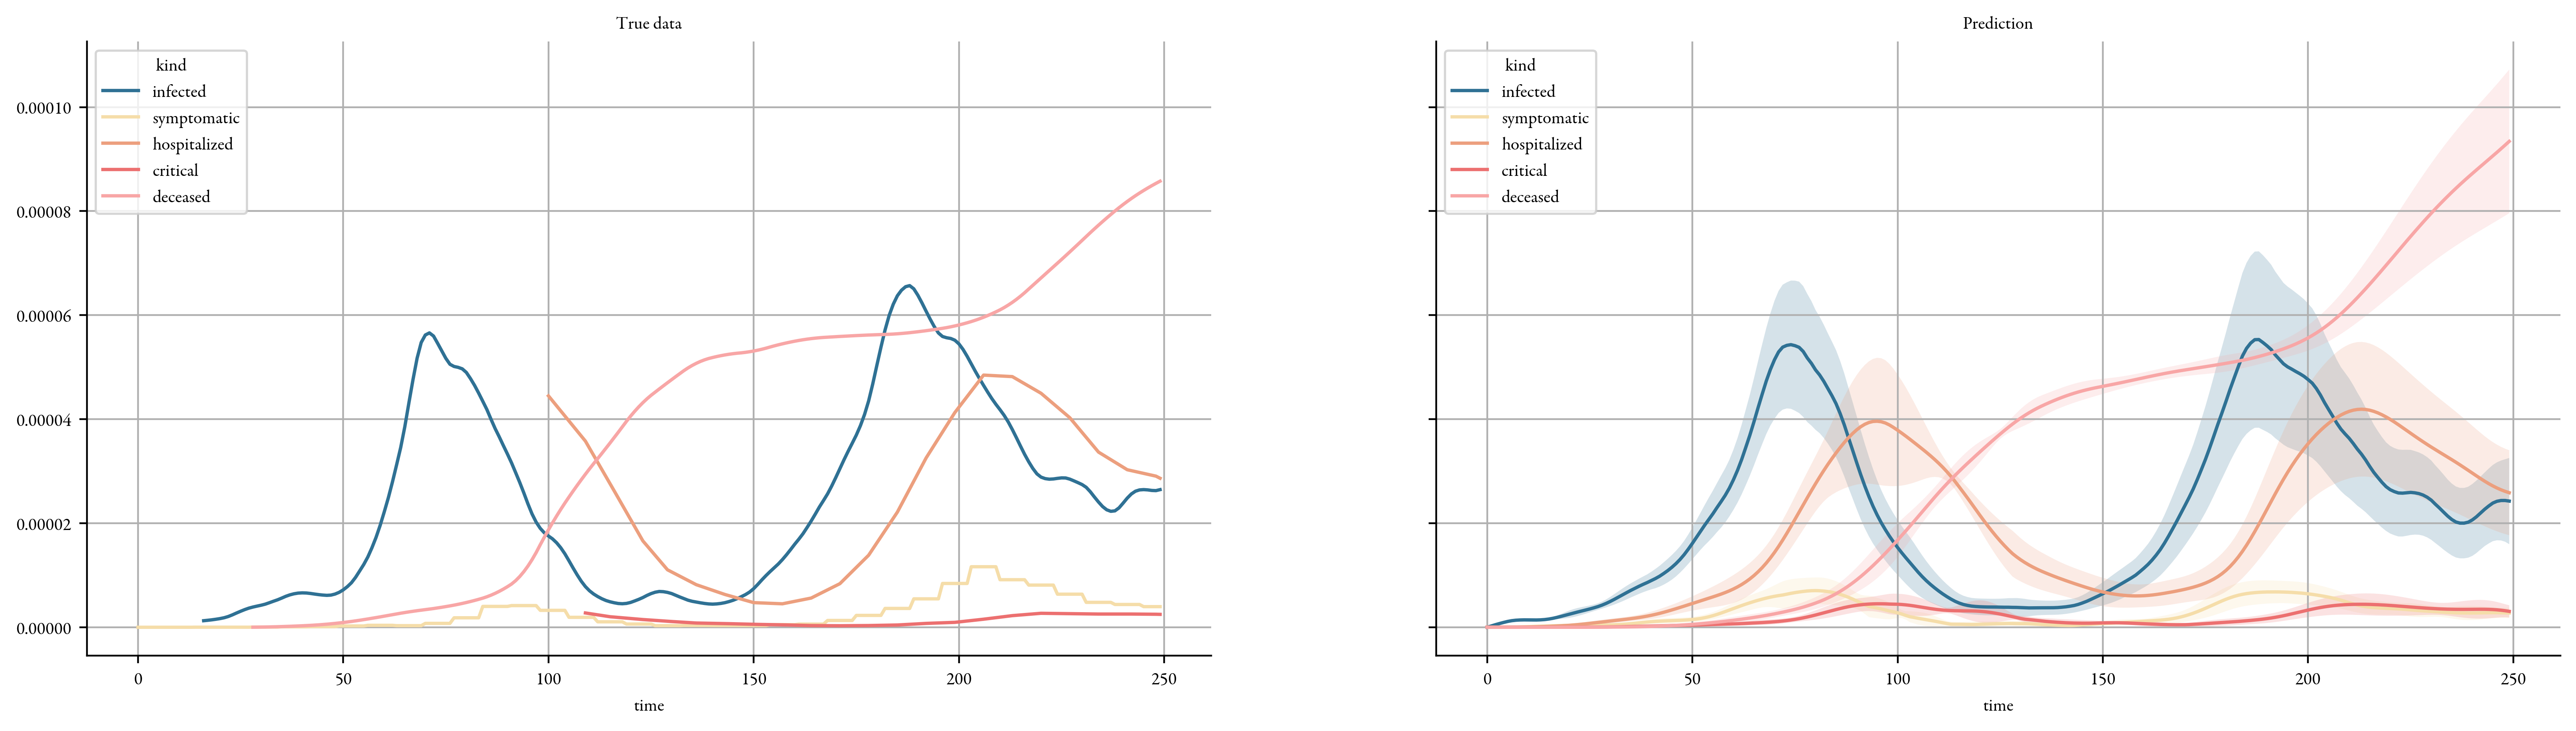

In [266]:
# Run the simulation for b steps:
fig, axs = plt.subplots(ncols=2, figsize=(20, 5), sharey=True)
predictions=[]
for s, _nn in enumerate(NN_infection):
    prediction = [initial_state.clone()]
    parameters = _nn(input_data[0]).detach()
    for _ in range(training_data.shape[0]-1):
        prediction.append(SEIRD(prediction, {'k_E': parameters[_+12], 
                                  'k_I': parameters[0], 
                                  'k_SY': parameters[1],
                                  'k_R': parameters[2], 
                                  'k_H': parameters[3], 
                                  'k_C': parameters[4], 
                                  'k_D': parameters[5], 
                               'tau_I': 1+10*parameters[6], 
                               'tau_SY': 1+10*parameters[7], 
                               'tau_H': 1+10*parameters[8], 
                               'tau_C': 1+10*parameters[9],
                               'tau_R': 1+10*parameters[10], 
                               'tau_D': 1+10*parameters[11]}, 
                  dt=0.1))
    predictions.append(xr.DataArray(torch.stack(prediction), dims=["time", "kind"], coords={"time": np.arange(training_data.shape[0]), "kind": [e.name for e in Compartments]}).expand_dims({'seed': [s]}))
    
predictions = xr.concat(predictions, dim="seed")
prds = predictions.sel({"kind": ["infected", "symptomatic", "hospitalized", "critical", "deceased"]})
xr.DataArray(training_data, dims=["time", "kind"], coords={"time": np.arange(training_data.shape[0]), "kind": prds.coords["kind"].data}).plot(hue="kind", ax=axs[0])
for kind in prds.coords["kind"].data:
    axs[1].fill_between(prds.coords["time"], prds.sel({"kind": kind}).mean("seed")-prds.sel({"kind": kind}).std("seed"), prds.sel({"kind": kind}).mean("seed")+prds.sel({"kind": kind}).std("seed"), alpha=0.2)
prds.mean("seed").plot(hue="kind", ax=axs[1])

axs[0].grid()
axs[1].grid()
axs[0].set_title("True data")
axs[1].set_title("Prediction")

---
# Step 2: Learn $k_E$-opinion coupling
---

In [152]:
anxiety_jp = pd.read_csv("/Users/thomasgaskin/Opinion_Dynamics_and_Covid/Opinion_data/Cross_Marketing_Japan/All_data/Anxiety-Anxiety level over the past week regarding Covid (1=None) (直近1週間の不安度).csv", index_col=0)
anxiety_jp.index = pd.to_datetime(anxiety_jp.index, dayfirst=True, format='mixed')

(18340.0, 19813.0)

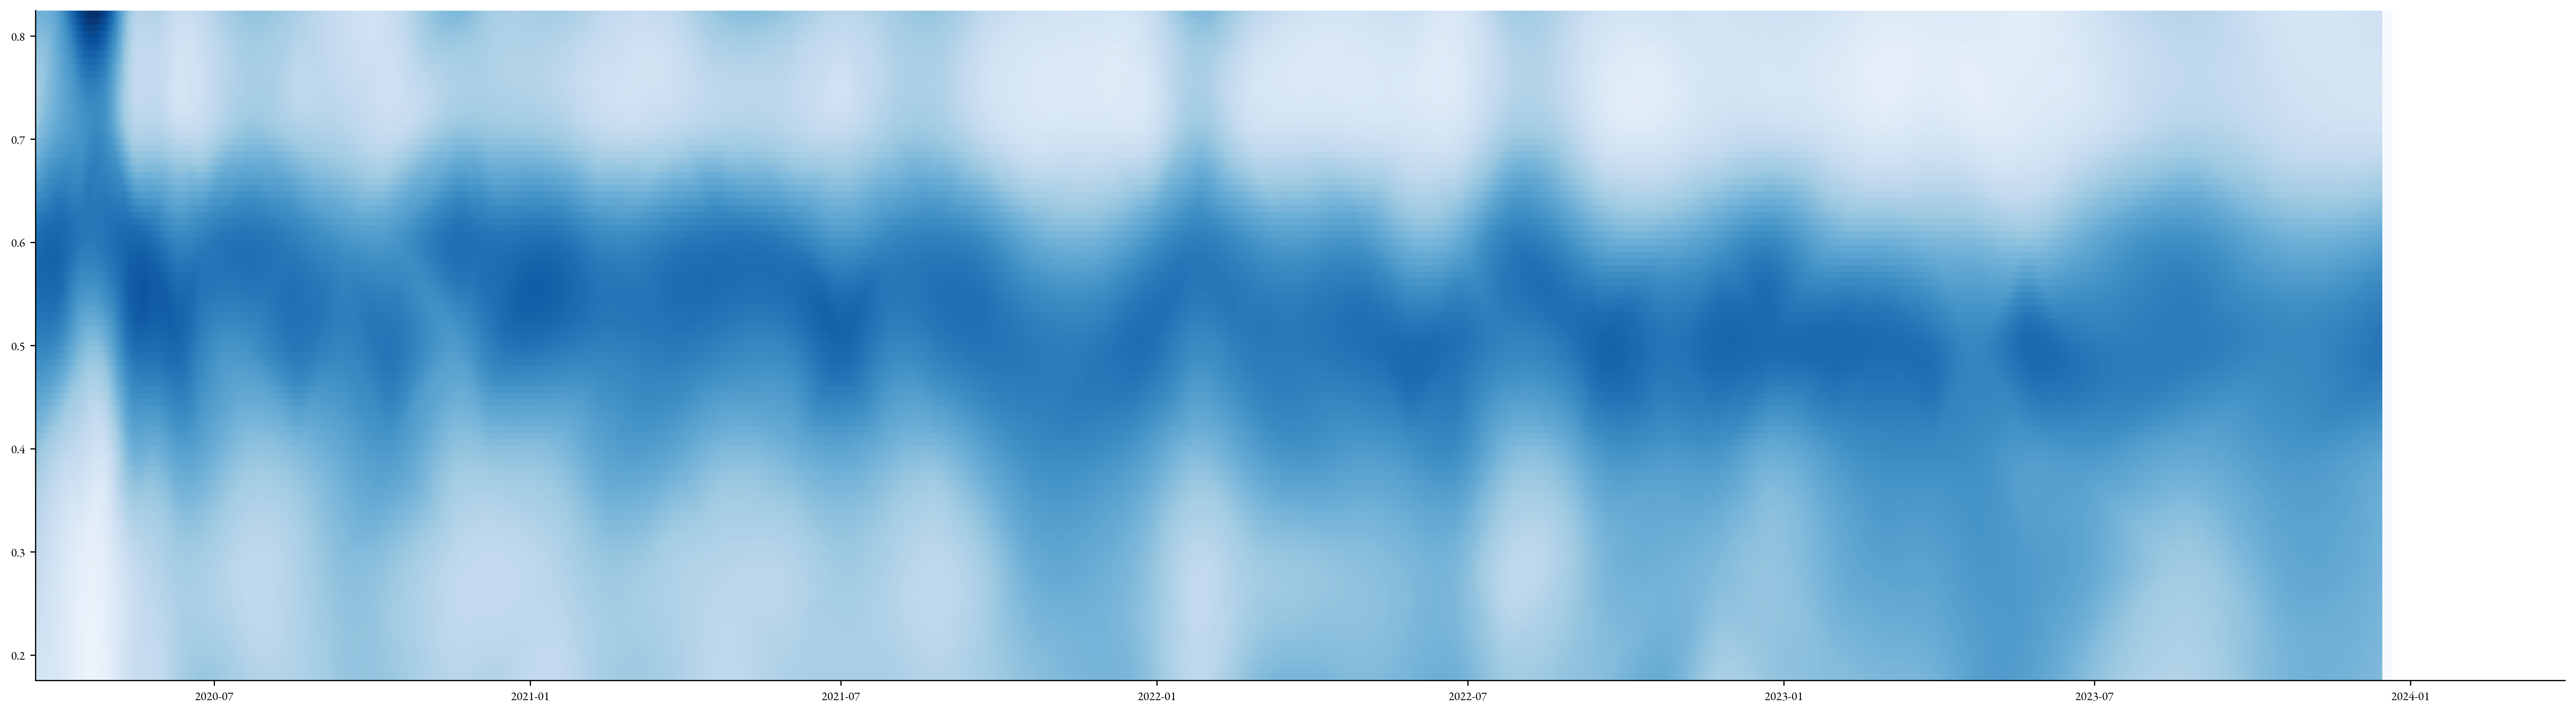

In [153]:
x, y, z = [], [], []
ds = anxiety_jp.stack().to_xarray().assign_coords({'level_1': np.array(list(range(1, len(anxiety_jp.columns)+1))) / (len(anxiety_jp.columns)+1)})
x.append(np.array([len(ds.coords['level_1']) * [_x] for _x in ds.coords['Date'].data]).flatten())
y.append(np.array(len(ds.coords['Date']) * list(ds.coords['level_1'])).flatten())
z.append(ds.data.flatten())
x = np.concatenate(x).astype(float)
y = np.concatenate(y)
z = np.concatenate(z)
x *= 1e-18
T = scipy.stats.binned_statistic_2d(x, y, z, bins=[100, 7], statistic='mean')
_t = (T.statistic / 100) / np.nansum(T.statistic / 100, axis=1, keepdims=True)
pts = np.meshgrid(0.5*(T.x_edge[1:]+T.x_edge[:-1]), 0.5*(T.y_edge[1:] + T.y_edge[:-1]))
coords = np.stack([pts[0], pts[1]], axis=-1).reshape(-1, 2)
vals = _t.transpose().flatten()
coords = coords[np.where(~np.isnan(vals))]
vals = vals[np.where(~np.isnan(vals))]
idx = np.random.choice(vals.shape[0], 10000)
dates_interp = np.arange(anxiety_jp.index.min(), anxiety_jp.index.max(), np.timedelta64(1, "D"))
X, Y = np.meshgrid(dates_interp.astype(float)*1e-15, 
                   np.linspace(coords.transpose()[1].min(), coords.transpose()[1].max(), 100))  # 2D grid for interpolation
interp = scipy.interpolate.griddata(coords[idx], vals[idx], (X, Y), method='cubic', fill_value=0)
fig, ax = plt.subplots(figsize=(30, 8))
ax.pcolormesh(dates_interp, Y, interp, cmap='Blues')
ax.set_xlim(infection_densities.index[60], infection_densities.index[-1])

In [251]:
training_data.shape, k_E_train.shape

(torch.Size([250, 5]), torch.Size([12, 250]))

In [155]:
opinion_data = torch.from_numpy(interp[:, 7:-6]).float()
start_date_idx = np.where(infection_densities.index == dates_interp[7])[0].item()
opinion_training_data = opinion_data[:, 0:len(training_data)-start_date_idx]
opinion_training_data.shape, start_date_idx

(torch.Size([100, 190]), 60)

In [252]:
NN_opinion = [
    neural_net.NeuralNet(
        input_size = opinion_data.shape[0], # We have five compartments
        output_size = 1, 
        num_layers=6,
        nodes_per_layer={"default": 60}, 
        activation_funcs={"default": "relu", "layer_specific": {-1: "abs"}}, 
        biases={"default": None}
    ) for _ in range(len(NN_infection))
]

In [253]:
batch_size = 60
n_epochs_op = 2000

In [256]:
for i in (pbar := tqdm.tqdm(range(k_E_train.shape[0]), total=k_E_train.shape[0] * n_epochs_op)):
    for _ in range(n_epochs_op):
        loss = torch.tensor(0.0, requires_grad=True)
        for t in range(opinion_training_data.shape[1]):
            err = torch.nn.functional.mse_loss(NN_opinion[i](opinion_training_data[:, t]), k_E_train[i][[start_date_idx+t]])
            loss = loss + err
            if t % batch_size == 0 or t >= opinion_training_data.shape[1]:
                loss.backward()
                NN_opinion[i].optimizer.step()
                NN_opinion[i].optimizer.zero_grad()
                loss = torch.tensor(0.0, requires_grad=True)
        pbar.update(1)

  0%|          | 12/24000 [13:05<436:12:51, 65.46s/it]


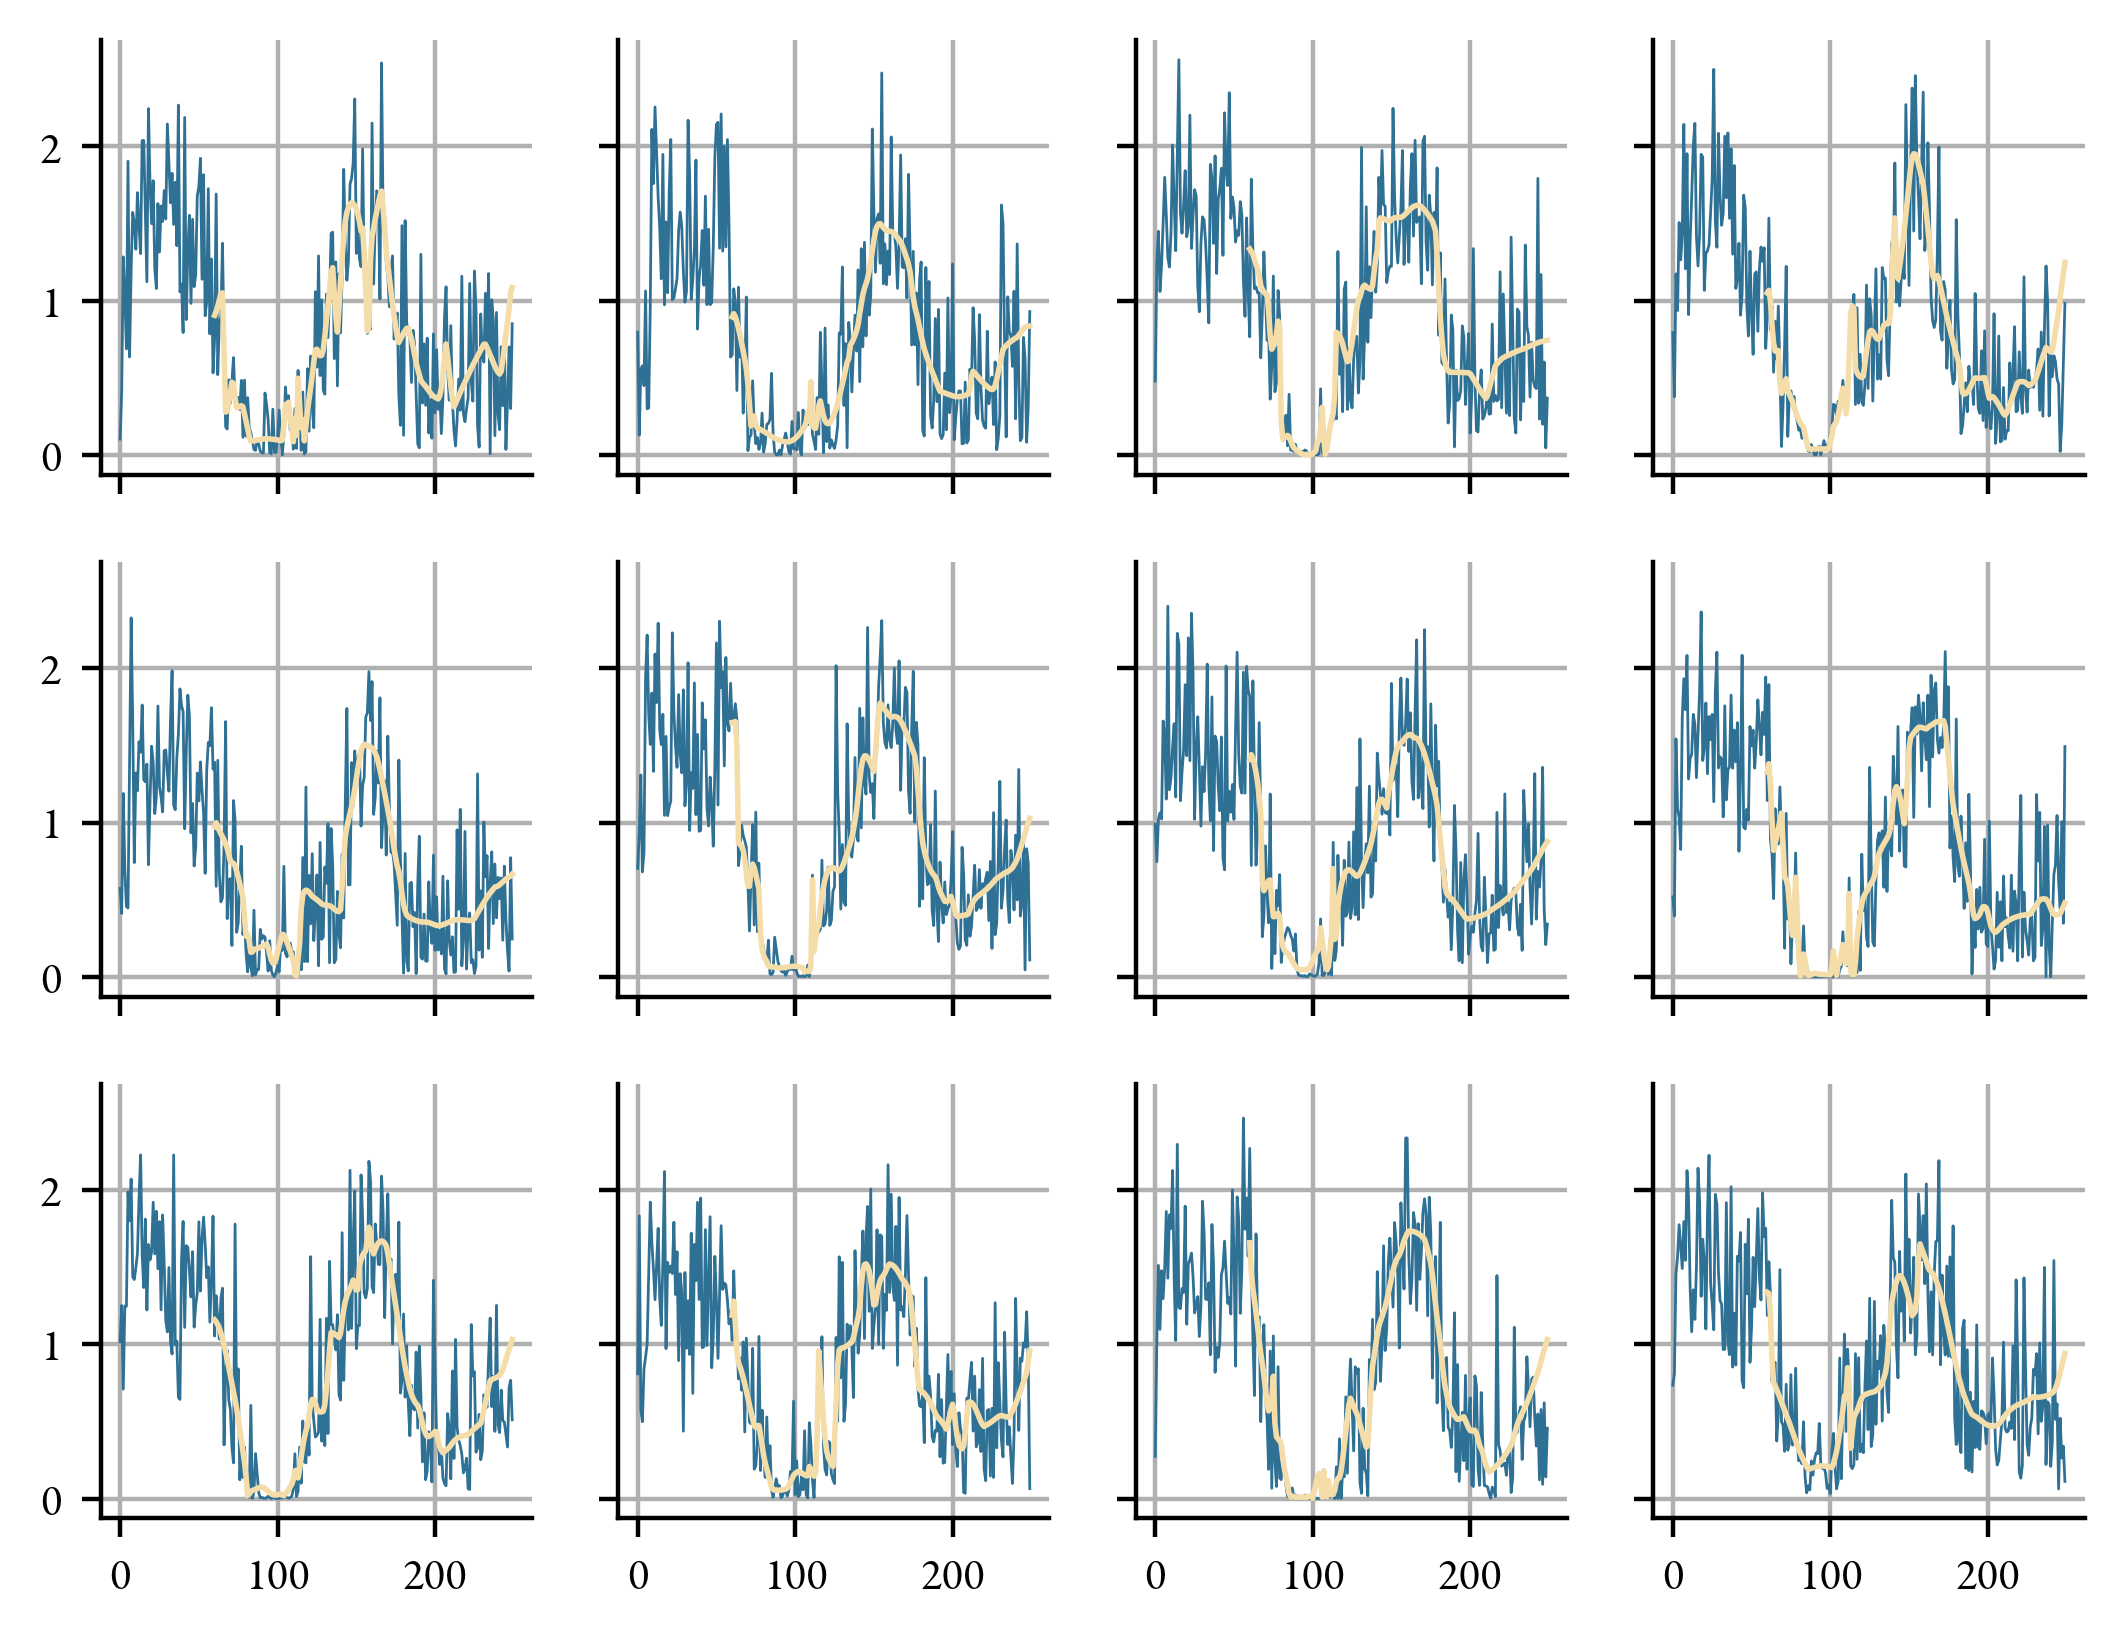

In [264]:
fig, axs = plt.subplots(ncols=4, nrows=3, sharex=True, sharey=True)
for i, ax in enumerate(axs.flatten()):
    ax.grid()
    ax.plot(np.arange(k_E_train.shape[1]), k_E_train[i], lw=0.5)
    ax.plot(np.arange(start_date_idx, start_date_idx+opinion_training_data.shape[1]), [NN_opinion[i](opinion_training_data[:, t]).detach() for t in range(opinion_training_data.shape[1])], lw=1)

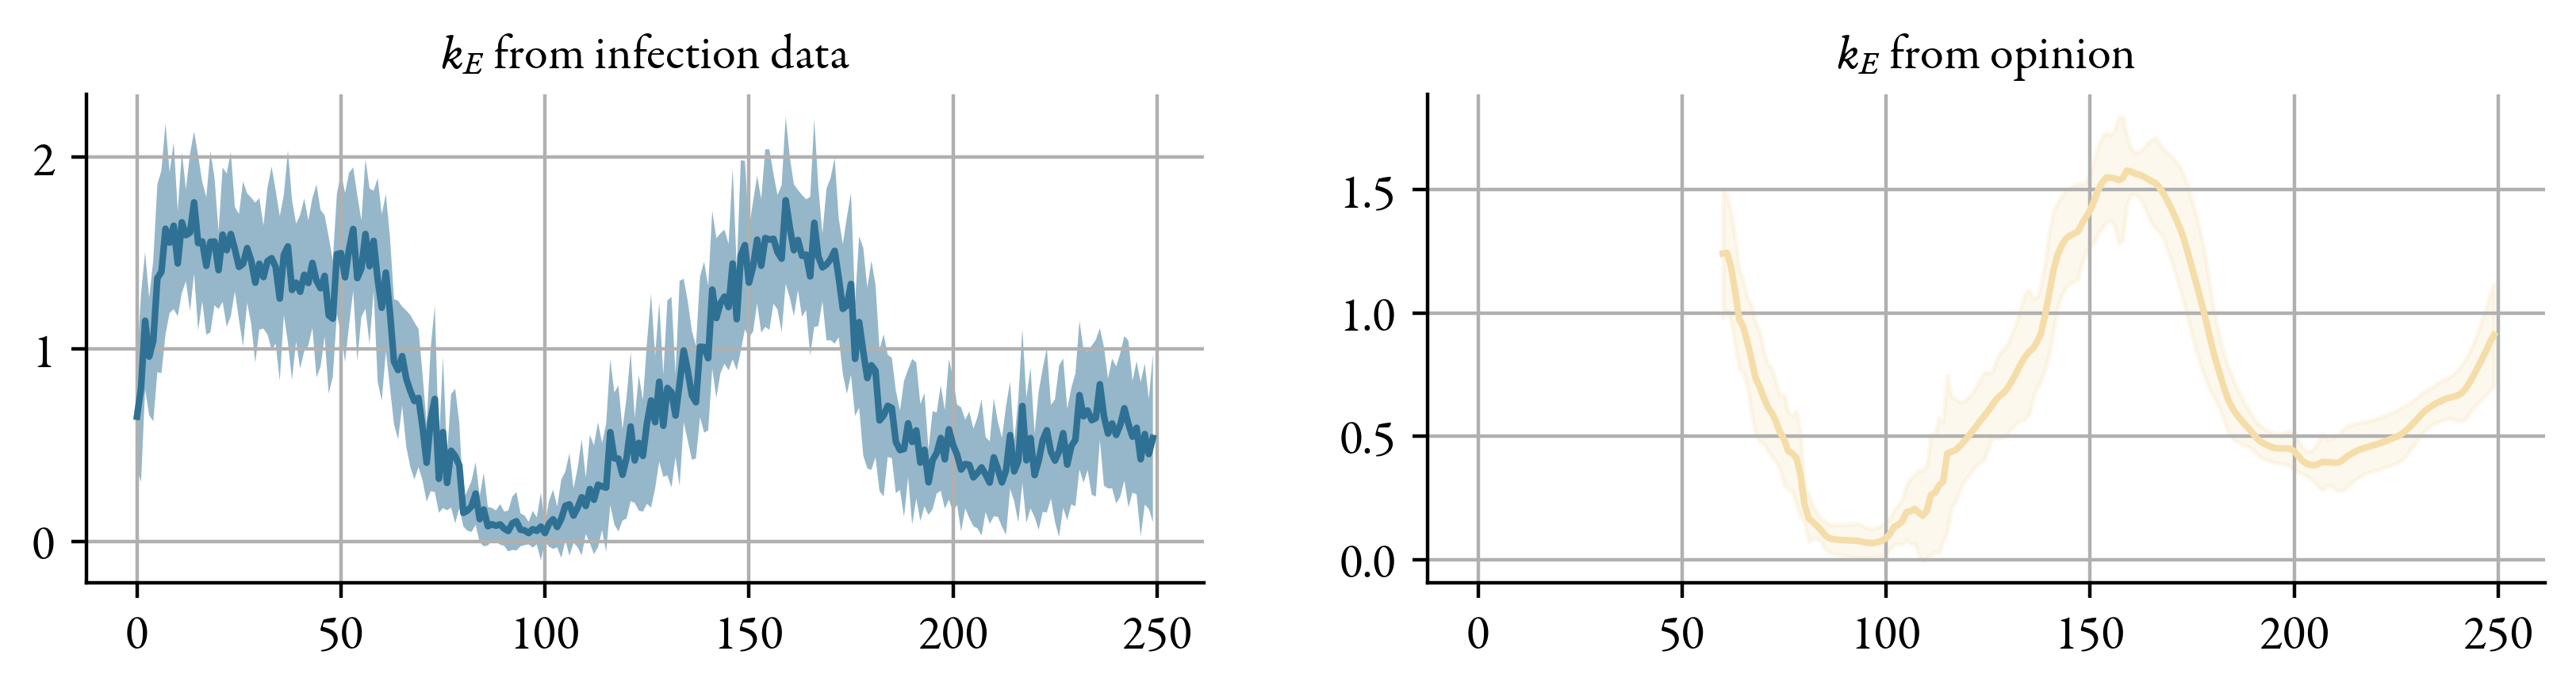

In [327]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 2), sharex=True)
axs[0].grid()
axs[1].grid()
axs[0].fill_between(np.arange(k_E_train.shape[1]), k_E_train.mean(axis=0)-k_E_train.std(axis=0), k_E_train.mean(axis=0)+k_E_train.std(axis=0), alpha=0.5)
axs[0].plot(np.arange(k_E_train.shape[1]), torch.stack([_nn(input_data[0]).detach()[12:] for _nn in NN_infection]).mean(axis=0))
axs[0].set_title("$k_E$ from infection data")

k_E_op = torch.stack([torch.stack([NN_opinion[i](opinion_training_data[:, t]).detach() for t in range(opinion_training_data.shape[1])]) for i in range(len(NN_opinion))]).squeeze()
axs[1].fill_between(np.arange(start_date_idx, start_date_idx+opinion_training_data.shape[1]), k_E_op.mean(axis=0)-k_E_op.std(axis=0), k_E_op.mean(axis=0)+k_E_op.std(axis=0), color=colors['c_yellow'], alpha=0.2)
axs[1].plot(np.arange(start_date_idx, start_date_idx+opinion_training_data.shape[1]), k_E_op.mean(axis=0), color=colors['c_yellow'])
axs[1].set_title("$k_E$ from opinion")

In [305]:
# Run the simulation for b steps:
predictions_from_op = []

for s, _nn in enumerate(NN_infection):
    prediction = [torch.from_numpy(predictions.sel({"seed": s}).isel({"time": start_date_idx}).data)]
    parameters = _nn(input_data[0]).detach()
    for _ in range(opinion_training_data.shape[1]-1 + 150):
        prediction.append(SEIRD(prediction, {'k_E': NN_opinion[s](opinion_data[:, _]).detach()[0], 
                                  'k_I': parameters[0], 
                                  'k_SY': parameters[1],
                                  'k_R': parameters[2], 
                                  'k_H': parameters[3], 
                                  'k_C': parameters[4], 
                                  'k_D': parameters[5], 
                               'tau_I': 1+10*parameters[6], 
                               'tau_SY': 1+10*parameters[7], 
                               'tau_H': 1+10*parameters[8], 
                               'tau_C': 1+10*parameters[9],
                               'tau_R': 1+10*parameters[10], 
                               'tau_D': 1+10*parameters[11]}, 
                  dt=0.1))
    predictions_from_op.append(xr.DataArray(torch.stack(prediction), dims=["time", "kind"], coords={"time": np.arange(start_date_idx, start_date_idx+len(prediction), 1), "kind": [e.name for e in Compartments]}).sel({"kind": ["infected", "symptomatic", "hospitalized", "critical", "deceased"]}).expand_dims({'seed': [s]}))

predictions_from_op = xr.concat(predictions_from_op, dim="seed")
_inf = xr.DataArray(infection_densities[start_date_idx:start_date_idx+len(predictions_from_op.coords["time"].data)].to_numpy(dtype=float), dims=["time", "kind"], coords={"time": infection_densities.index[start_date_idx:start_date_idx+len(predictions_from_op.coords["time"].data)].values, "kind": ["infected", "symptomatic", "hospitalized", "critical", "deceased"]})
predictions_from_op = predictions_from_op.assign_coords({"time": _inf.coords["time"].data})

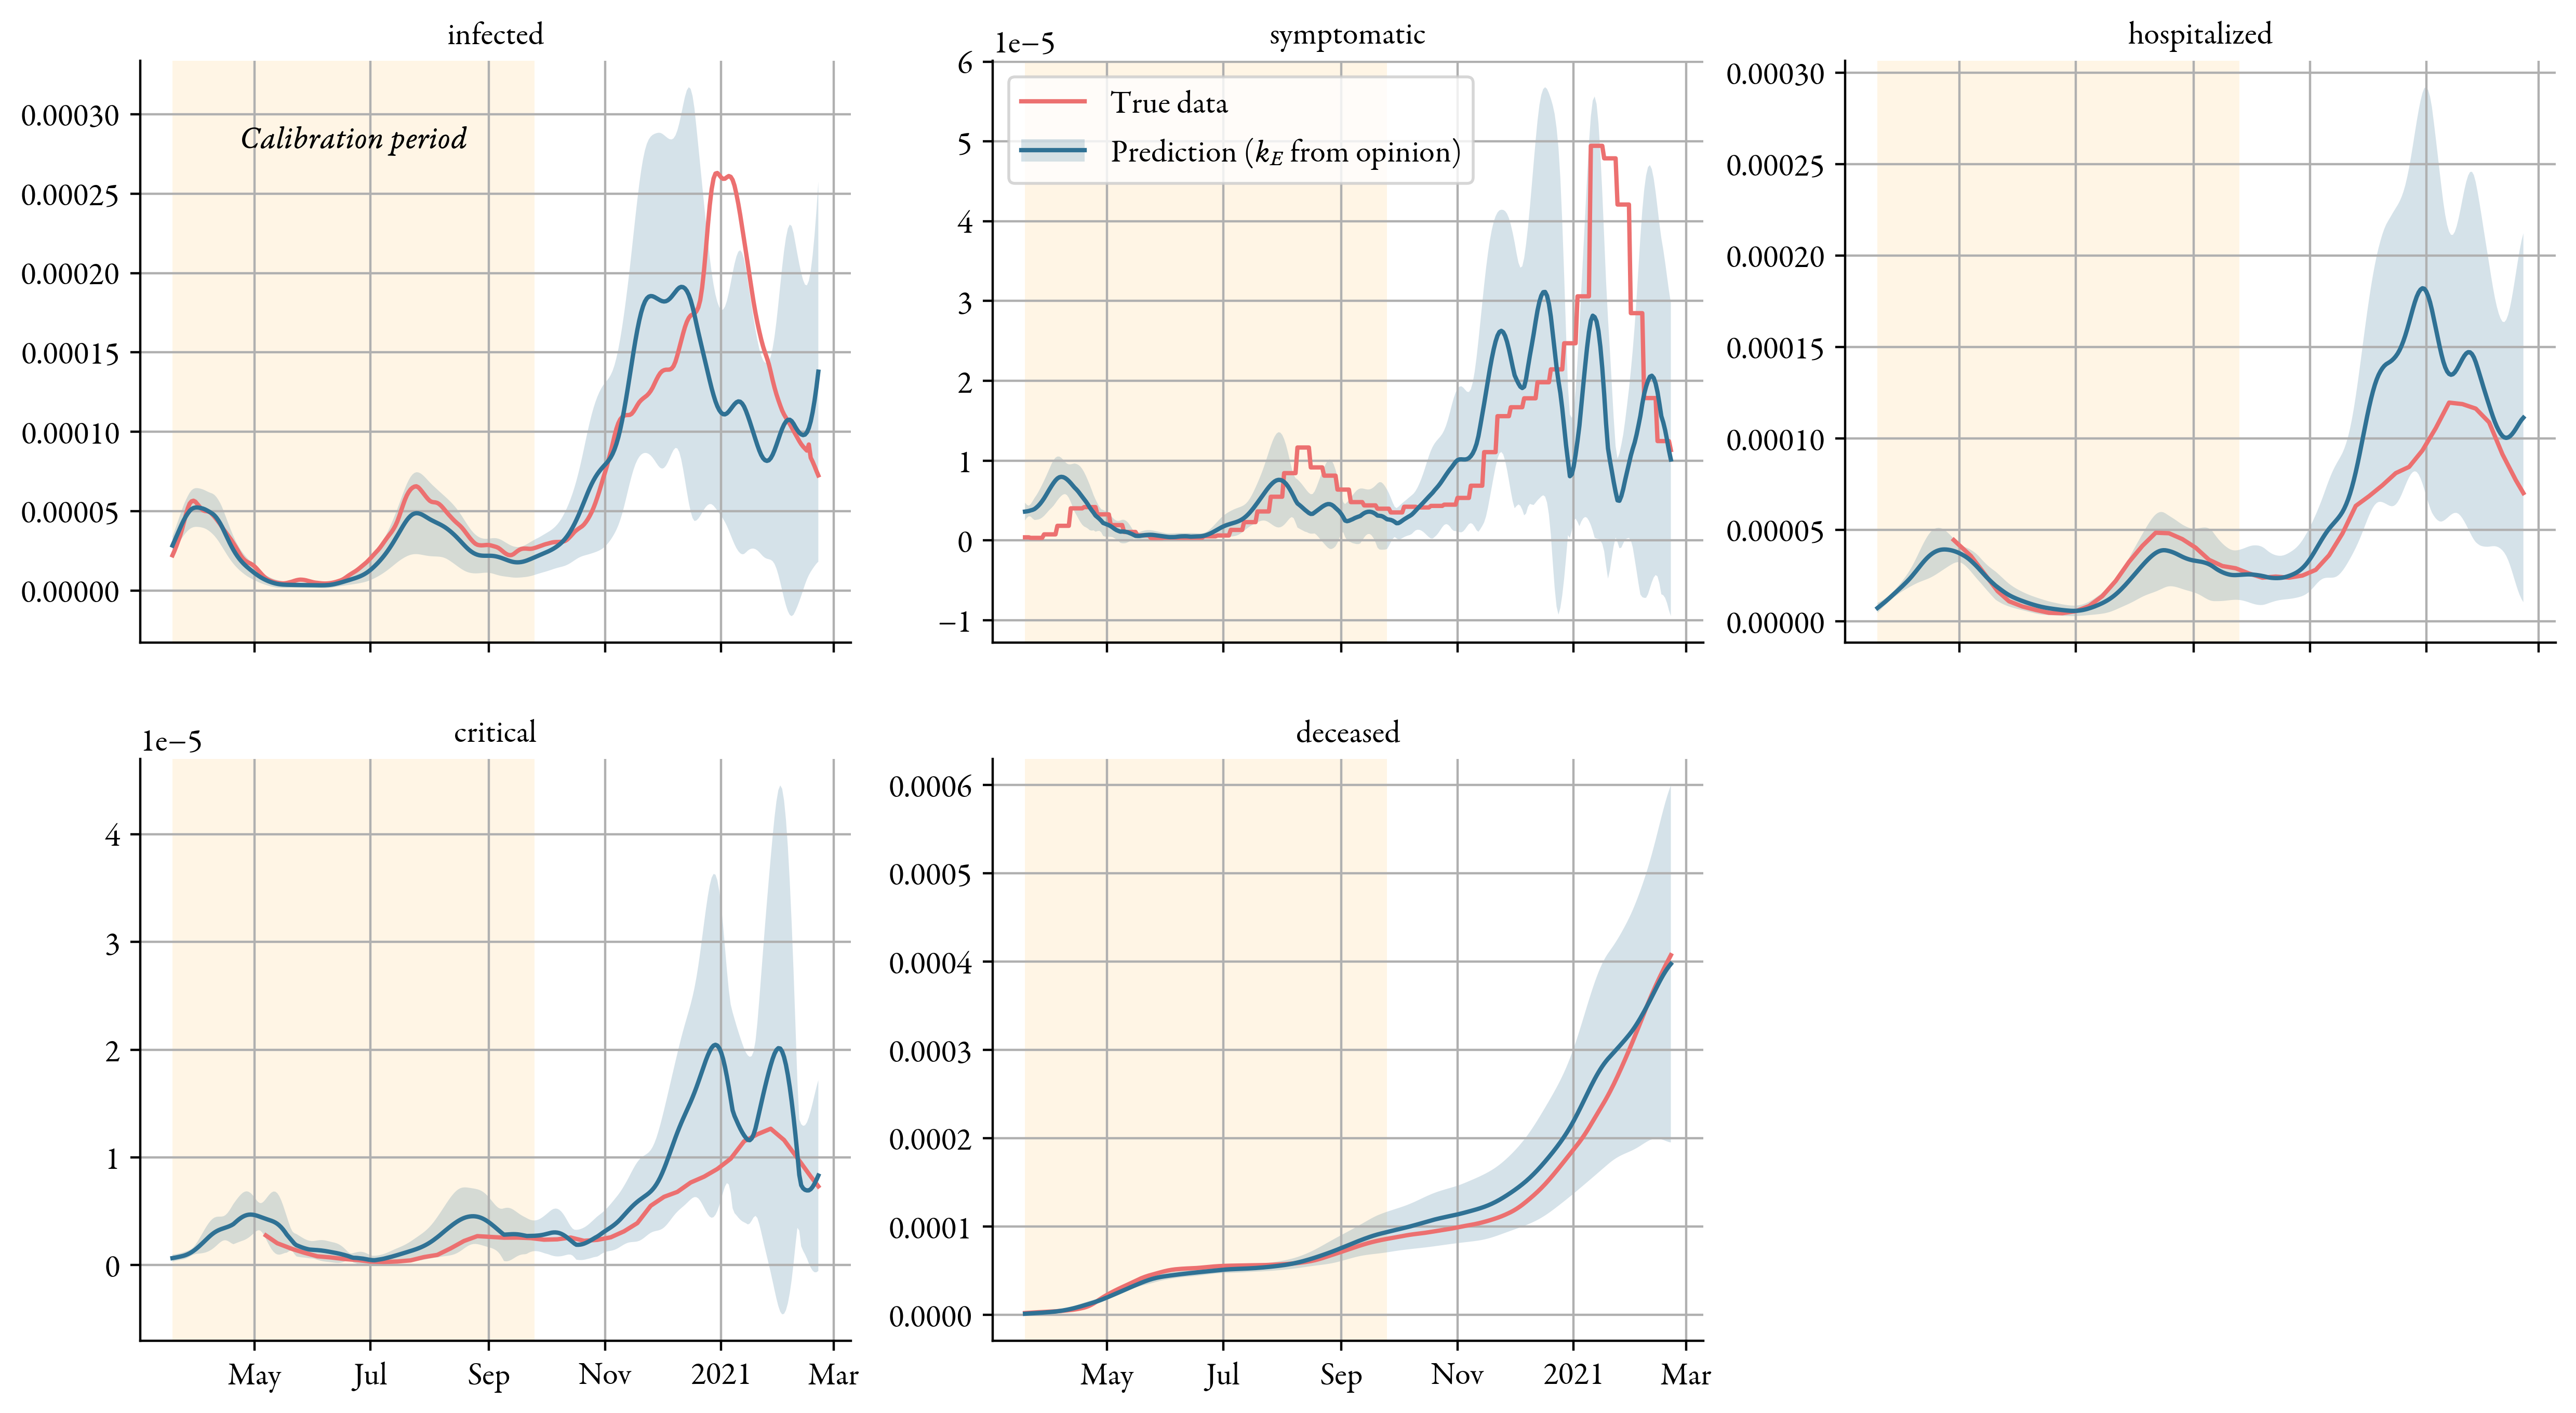

In [330]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 8), 
                        sharey=False, sharex=True)
for idx, kind in enumerate(prds.coords["kind"].data):
    
    m1 = _inf.sel({"kind": kind}).plot(ax=axs.flatten()[idx], add_legend=False, color=colors['c_red'])
    e2 = axs.flatten()[idx].fill_between(predictions_from_op.coords["time"], predictions_from_op.sel({"kind": kind}).mean("seed")-predictions_from_op.sel({"kind": kind}).std("seed"), predictions_from_op.sel({"kind": kind}).mean("seed")+predictions_from_op.sel({"kind": kind}).std("seed"), alpha=0.2)
    m2 = predictions_from_op.mean("seed").sel({"kind": kind}).plot(ax=axs.flatten()[idx])
    axs.flatten()[idx].set_title(f"{kind}")
    axs.flatten()[idx].grid()
    axs.flatten()[idx].axvspan(_inf.coords["time"].data[0], _inf.coords["time"].data[opinion_training_data.shape[1]], color='orange', alpha=0.1, lw=0, zorder=-2)
    axs.flatten()[idx].set_xlabel('')
axs[0, 1].legend(handles=[m1[0], (m2[0], e2)], labels=['True data', 'Prediction ($k_E$ from opinion)'])
axs[-1, -1].axis('off')
axs[0, 0].text(0.3, 0.85, 'Calibration period', transform=axs[0, 0].transAxes, ha='center', style='italic')

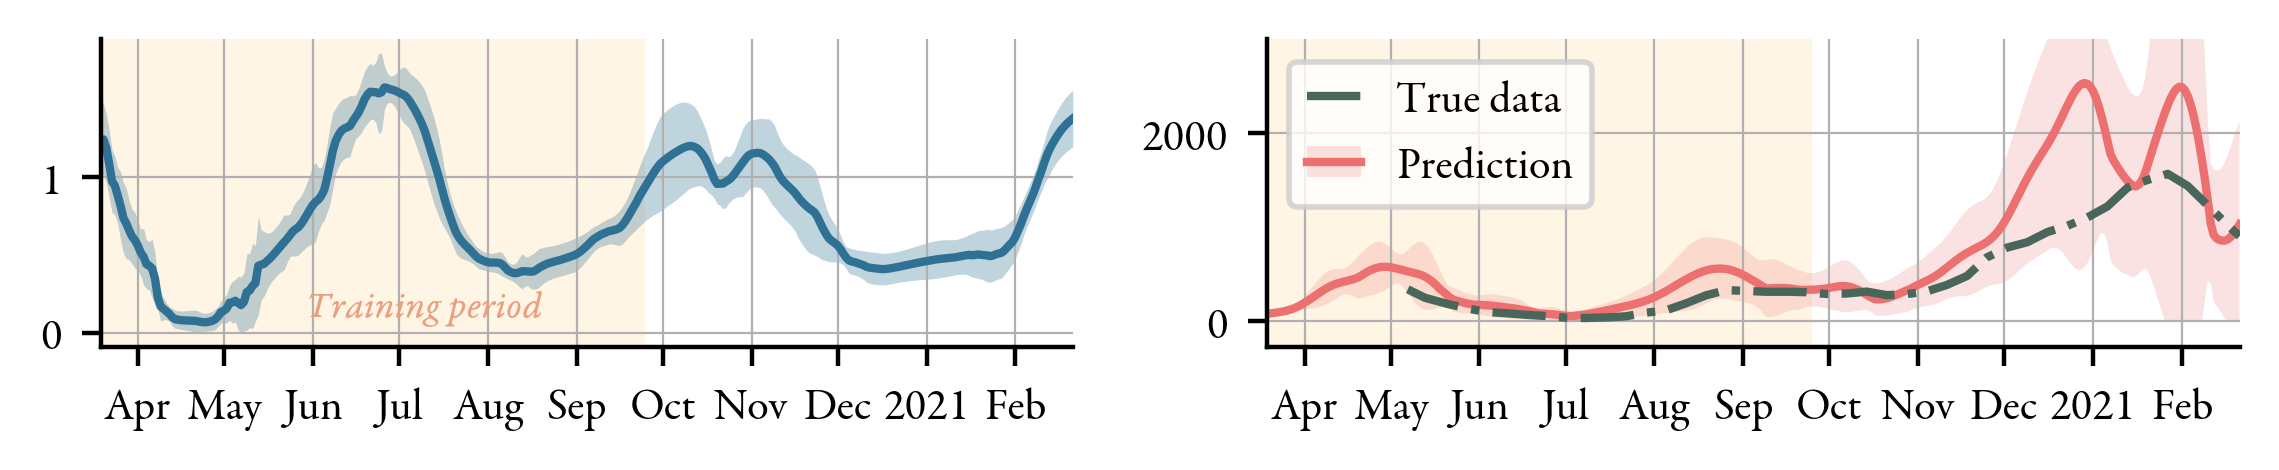

In [435]:
fig, axs = plt.subplots(ncols=2, figsize=(6.9, 1), sharex=True)

e2 = axs[1].fill_between(predictions_from_op.coords["time"], np.maximum(0, N*(predictions_from_op.sel({"kind": "critical"}).mean("seed")-predictions_from_op.sel({"kind": "critical"}).std("seed"))), N*(predictions_from_op.sel({"kind": "critical"}).mean("seed")+predictions_from_op.sel({"kind": "critical"}).std("seed")), alpha=0.2, color=colors['c_red'], lw=0)
m2 = (N*predictions_from_op).mean("seed").sel({"kind": "critical"}).plot(ax=axs[1], color=colors['c_red'])
m1 = (N*_inf.sel({"kind": "critical"})).plot(ax=axs[1], add_legend=False, color=colors['c_darkgreen'], ls='-.')
axs[1].set_xlabel('')
axs[1].set_title('')
axs[1].legend(handles=[m1[0], (m2[0], e2)], labels=['True data', 'Prediction'], handlelength=1.2, loc='upper left')

k_E_op = torch.stack([torch.stack([NN_opinion[i](opinion_data[:, t]).detach() for t in range(len(_inf.coords["time"].data))]) for i in range(len(NN_opinion))]).squeeze()
axs[0].fill_between(_inf.coords["time"], k_E_op.mean(axis=0)-k_E_op.std(axis=0), k_E_op.mean(axis=0)+k_E_op.std(axis=0), color=colors['c_darkblue'], alpha=0.3, lw=0)
axs[0].plot(_inf.coords["time"], k_E_op.mean(axis=0), color=colors['c_darkblue'], label="$k_E$ from opinion")
axs[1].set_ylim(None, 3000)
for ax in axs:
    ax.grid(lw=0.4)
    ax.axvspan(_inf.coords["time"].data[0], _inf.coords["time"].data[opinion_training_data.shape[1]], color='orange', alpha=0.1, lw=0, zorder=-2)
    ax.set_xlim(_inf.coords["time"][0], _inf.coords["time"][-1])
axs[0].text(0.21, 0.1, 'Training period', style='italic', transform=axs[0].transAxes, fontsize=7, color=colors['c_orange'])
fig.savefig("/Users/thomasgaskin/demo.pdf", bbox_inches='tight', transparent=True)